In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/518_project"

/content/drive/MyDrive/518_project


In [3]:
!pip install --upgrade pip
!pip install mxnet
!pip install gluonts
!pip install orjson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 854.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 4.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [5]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.mx import MQCNNEstimator
from gluonts.mx.distribution import ISQFOutput, GaussianOutput
from gluonts.evaluation import make_evaluation_predictions, Evaluator

## Gaussian Data

In [6]:
N = 1  # number of time series
T = 24*60  # number of timesteps
prediction_length = 24
freq = "H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2023", freq=freq)

In [7]:
custom_dataset.shape

(1, 1440)

(array([ 11.,  50., 120., 295., 377., 329., 189.,  49.,  16.,   4.]),
 array([-3.08471977, -2.41138963, -1.7380595 , -1.06472936, -0.39139922,
         0.28193092,  0.95526105,  1.62859119,  2.30192133,  2.97525147,
         3.6485816 ]),
 <BarContainer object of 10 artists>)

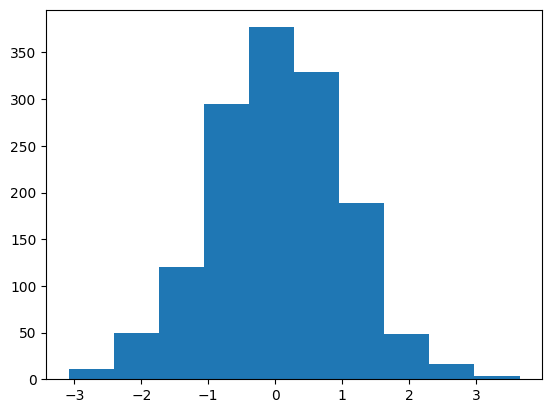

In [8]:
plt.hist(custom_dataset[0])

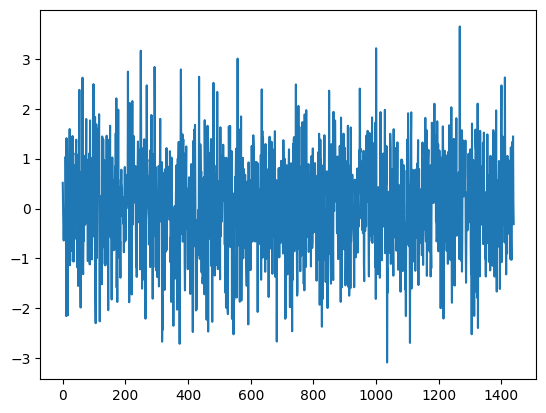

In [9]:
plt.plot(custom_dataset[0])

## Split Train/Test

In [104]:
# train and calibrate on the last 24 of train
train_dataset = custom_dataset[:,:-prediction_length]
# test on the last 24 data

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in train_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
calib_ds = ListDataset(
    [{"target": x, "start": start} for x in train_dataset], freq=freq
)

## Model Training

In [11]:
isqf_output = ISQFOutput(
    num_pieces=5,
    qk_x=[0.1, 0.3, 0.5, 0.7, 0.9]
)

mqcnn_estimator = MQCNNEstimator(
    freq = 'H',
    prediction_length=prediction_length,
    distr_output=isqf_output,
    trainer = Trainer(epochs=20)
)

In [12]:
predictor = mqcnn_estimator.train(train_ds)

100%|██████████| 50/50 [01:50<00:00,  2.20s/it, epoch=20/20, avg_epoch_loss=0.135]


## Model Evaluation

In [110]:
calibrate_it, ts_it = make_evaluation_predictions(
    dataset=calib_ds,  # calibration dataset
    predictor=predictor,  # predictor
)
calibrate_it = list(calibrate_it)
tss = list(ts_it)

## Quantile plots

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,5)

In [111]:
quantiles = [0.01, 0.2, 0.3, 0.5, 0.7, 0.8, 0.99]
calib_quantiles_df = pd.DataFrame({
    f'alpha_{q}': calibrate_it[0].quantile(q) for q in quantiles
})


fig, ax = plt.subplots(dpi=300)

for c in calib_quantiles_df.columns:
  ax.plot(calib_quantiles_df.loc[:,c], label=c)

plt.ylabel('Prediction Value')
plt.xlabel('Prediction Step')
plt.title('Quantile Crossing ISQF 5 knots')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()


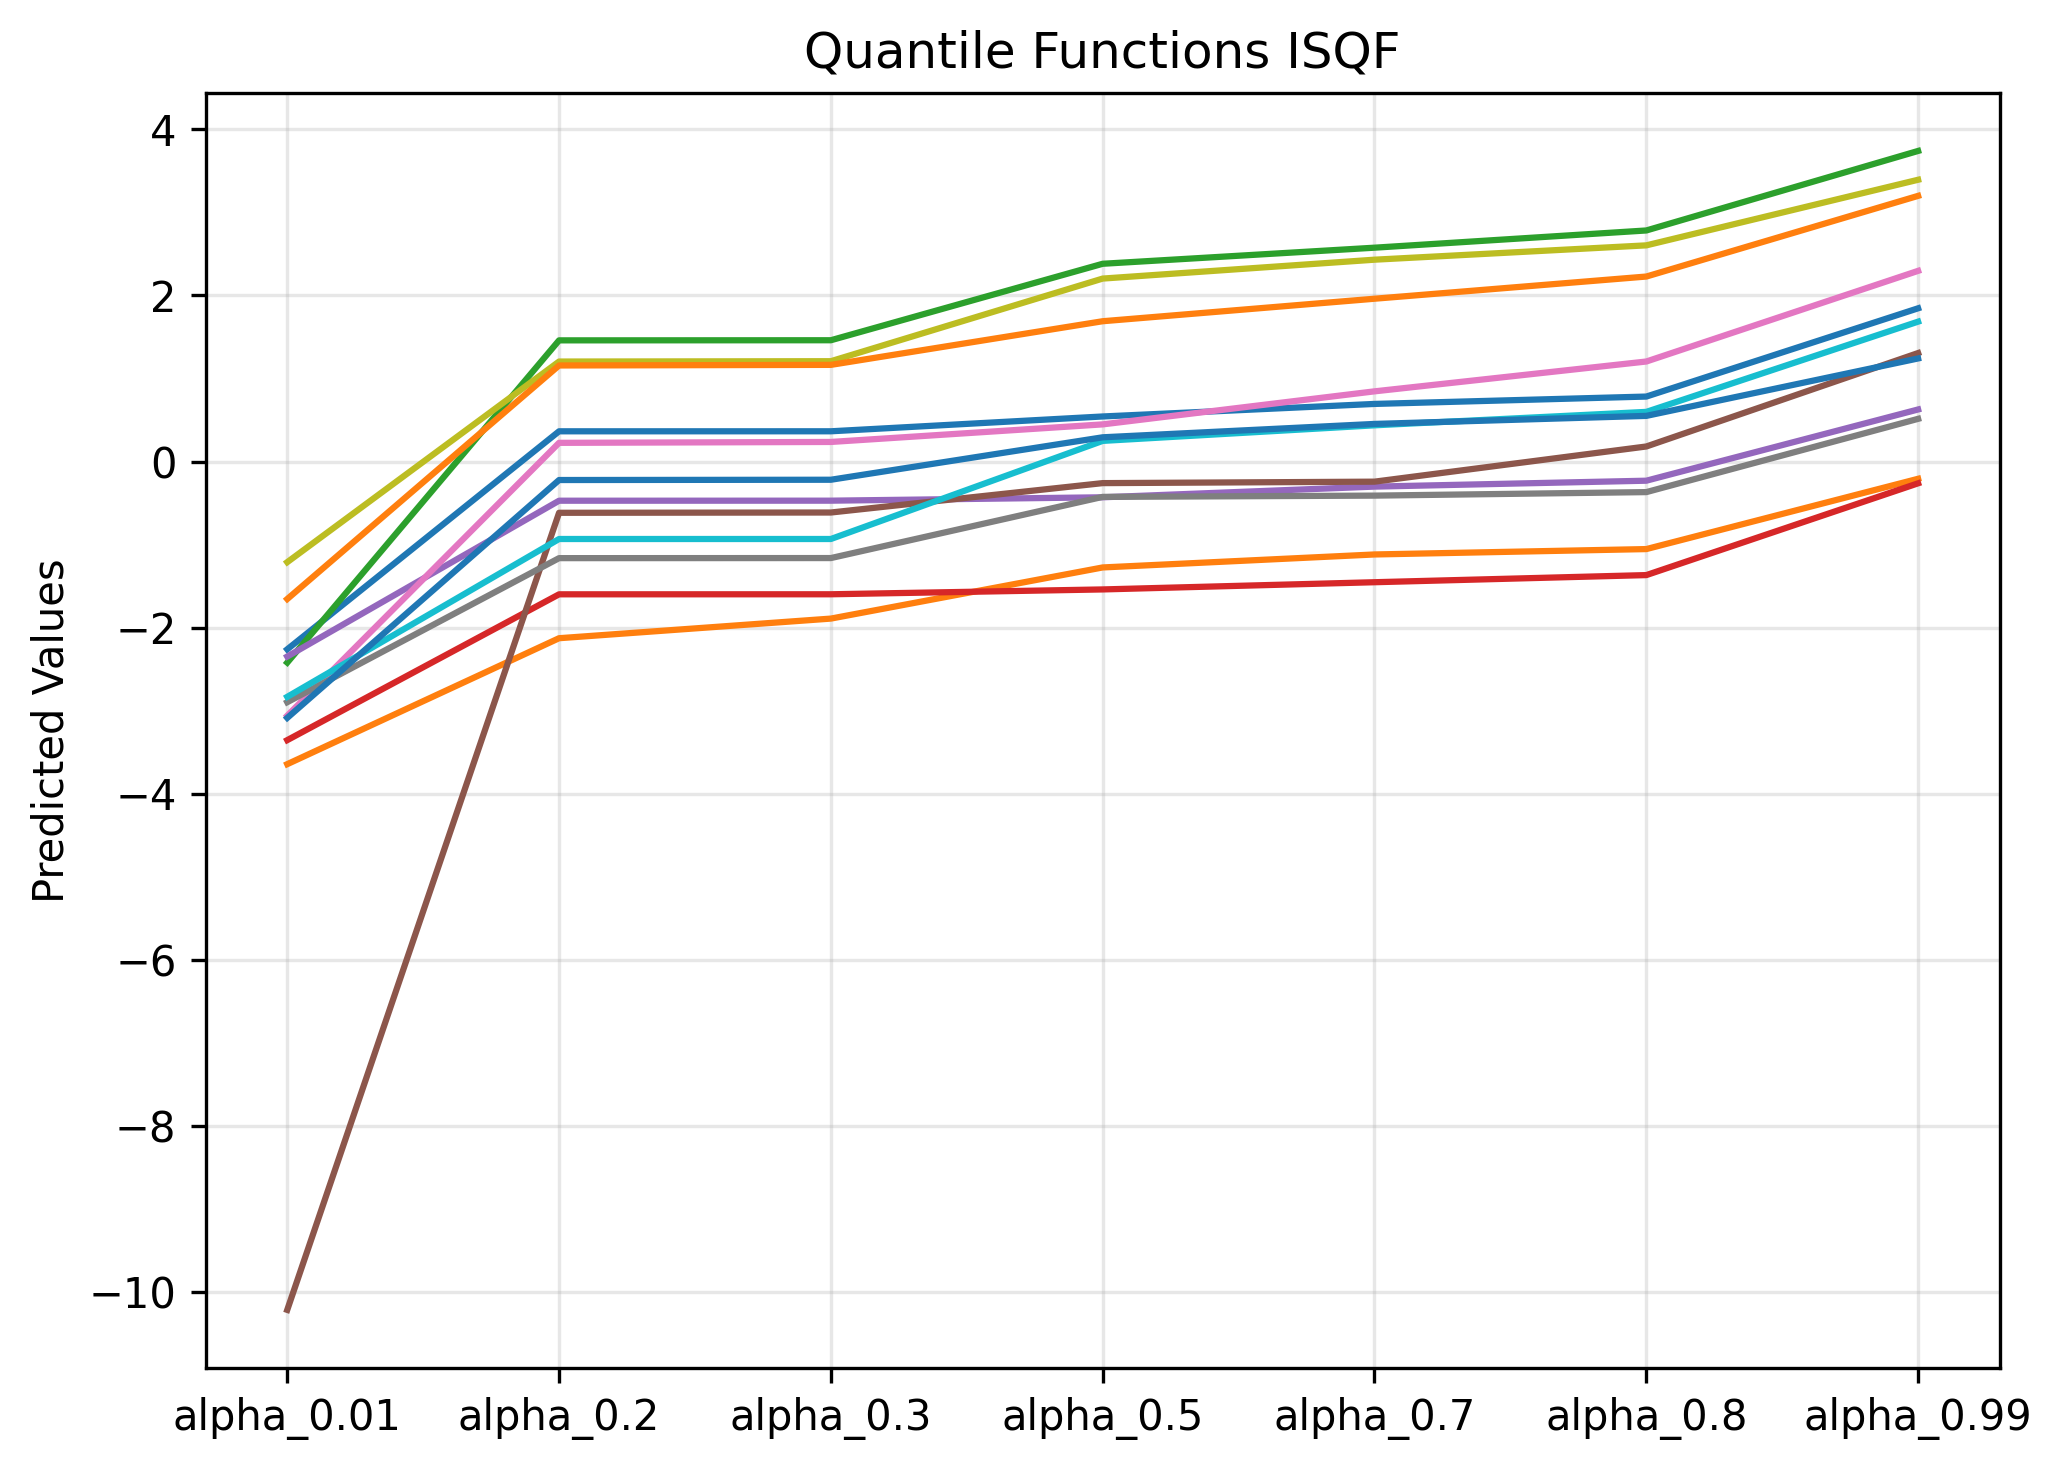

In [112]:
# Plot some quantile functions
fig, ax = plt.subplots(dpi=300)
for r in range(12):
  ax.plot(calib_quantiles_df.iloc[r])

plt.ylabel('Predicted Values')
plt.title('Quantile Functions ISQF')
plt.grid(alpha=0.3)
plt.tight_layout()

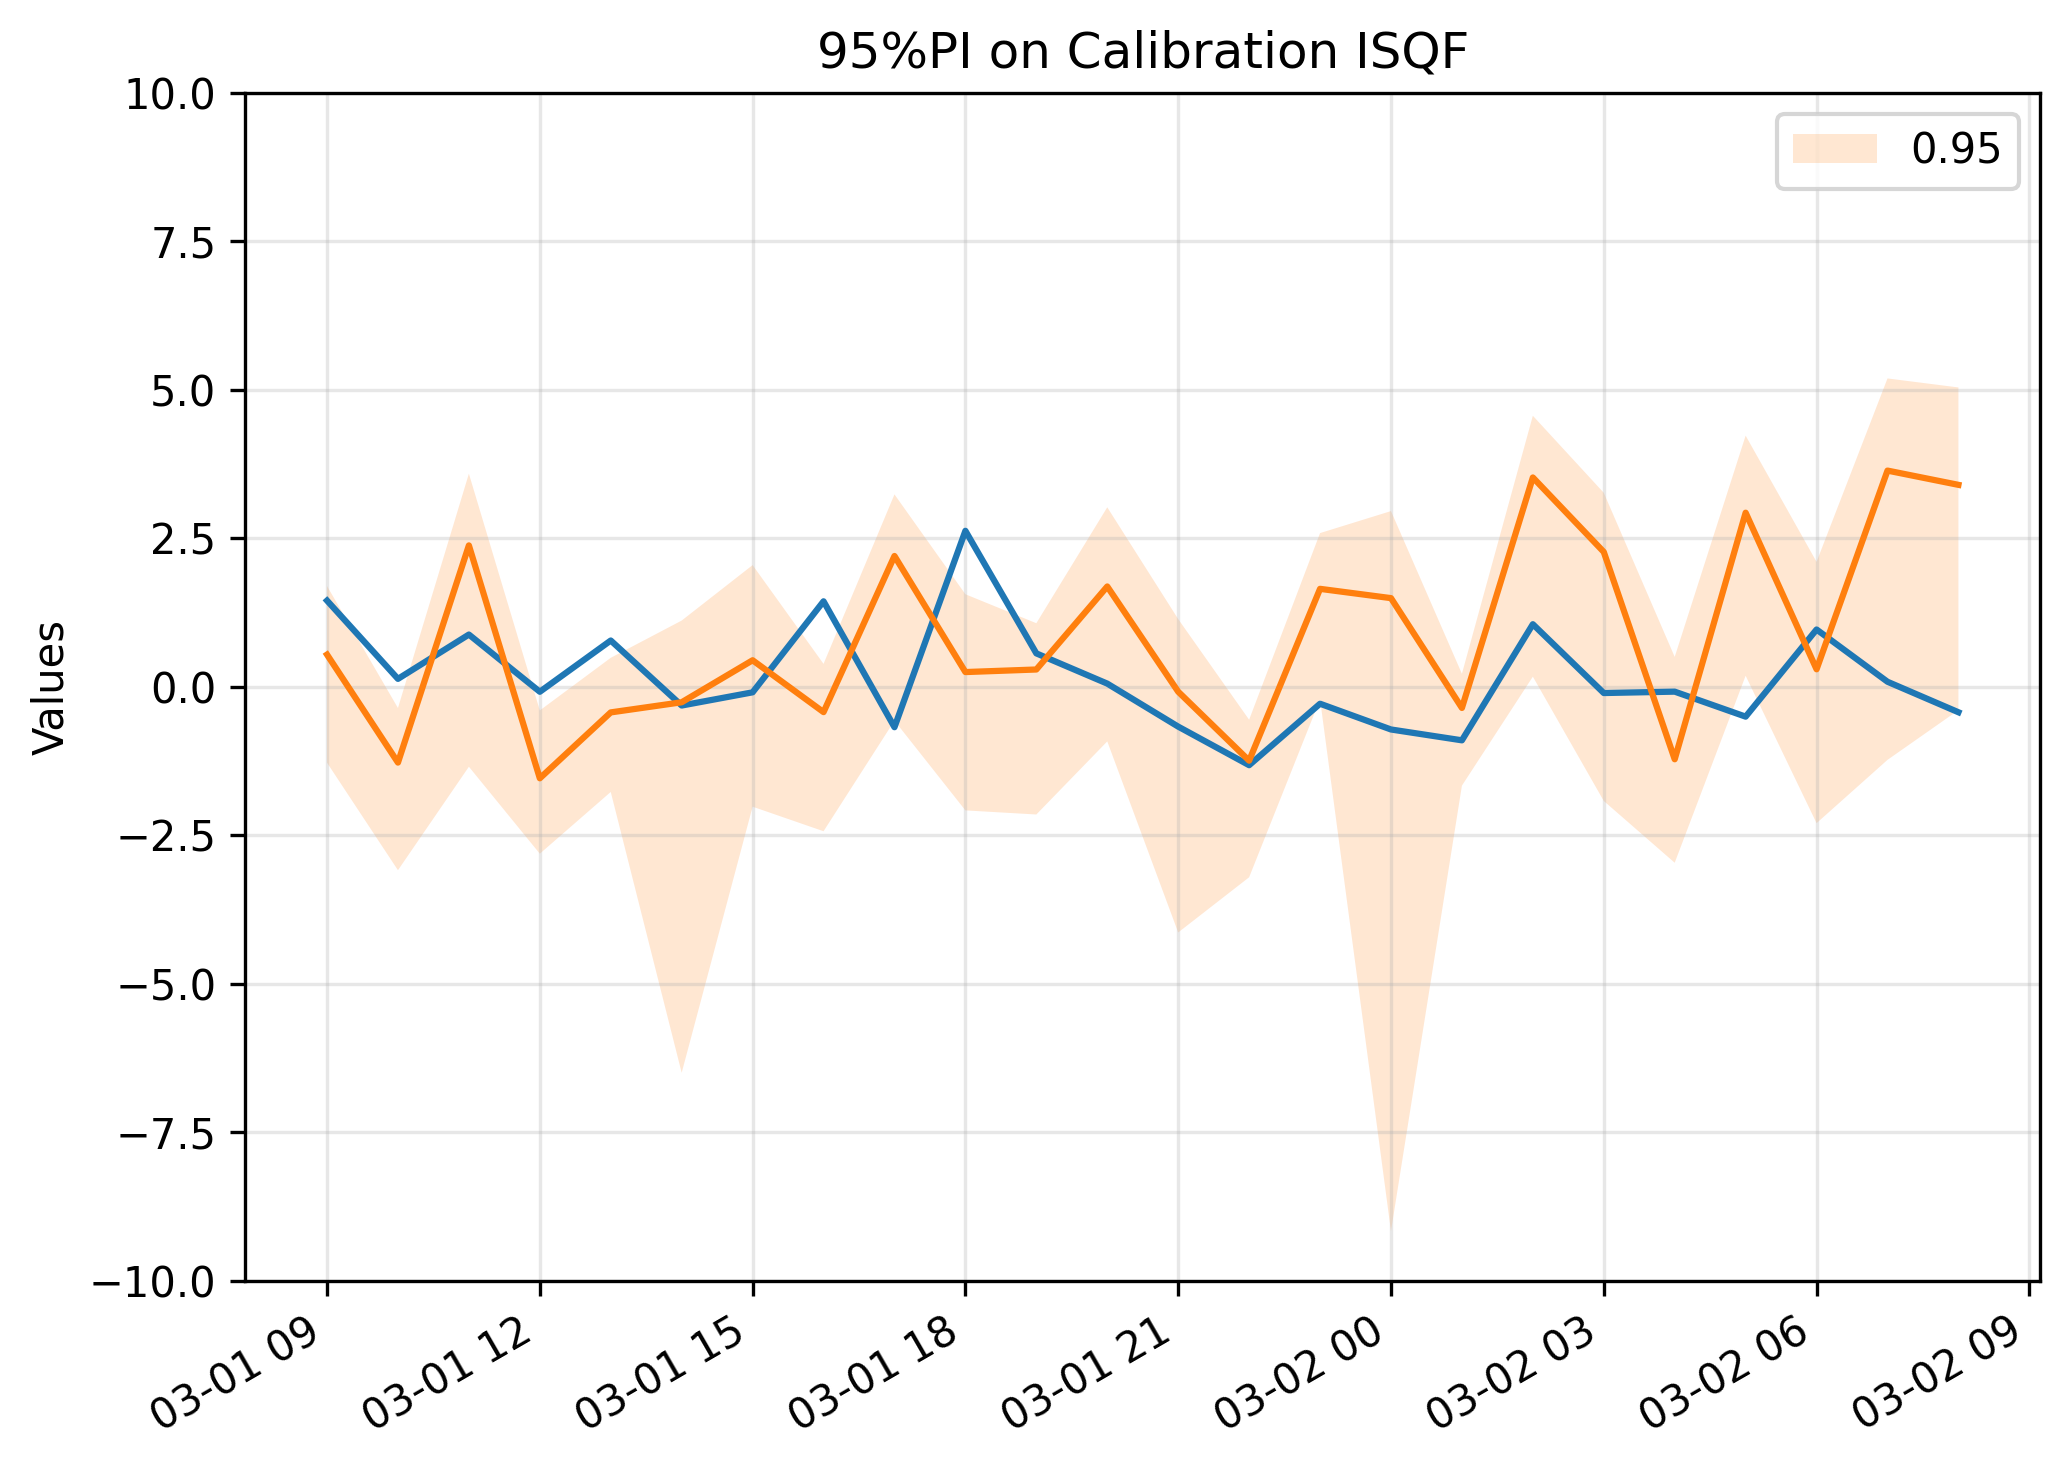

In [113]:
fig, ax = plt.subplots(dpi=300)
ax.plot(tss[0][-24:].to_timestamp())
calibrate_it[0].plot(intervals=[0.95],show_label=True)
plt.title("95%PI on Calibration ISQF")
plt.ylabel("Values")
plt.ylim(-10, 10)
plt.grid(alpha=0.3)
plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

## Calibration

In [114]:
import math
def binary_search_for_alpha(y, date, calib_q_function, precision=1e-3):
    lower_bound = 0
    upper_bound = 1
    while upper_bound - lower_bound > precision:
        mid = (upper_bound + lower_bound) / 2
        quantile_value = calib_q_function.quantile_ts(mid)[date]

        if quantile_value == y:
            return mid
        elif quantile_value < y:
            lower_bound = mid
        else:
            upper_bound = mid

    # Returning the midpoint of the final interval
    return (upper_bound + lower_bound) / 2

In [115]:
calib_set = []
valid_ds = tss[0][-24:][0]
valid_idx = valid_ds.index
for date, y in zip(valid_idx, valid_ds.values):

  q_hat = binary_search_for_alpha(y, date, calibrate_it[0])
  calib_set.append(q_hat)
calib_set.sort()


In [116]:
fig, ax = plt.subplots(dpi=300)
ax.hist(calib_set, bins=20, edgecolor='black')
ax.set_title('Histogram of Random Calibration Scores')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [22]:
def interpolation_random(scores):
  scores_map = {}
  n = len(scores)
  for i, s in enumerate(scores):
    scores_map[s] = (i + np.random.random())/(n+1)
  return scores_map

def interpolation_naive(scores):
  scores_map = {}
  n = len(scores)
  for i, s in enumerate(scores):
    scores_map[s] = i/n
  return scores_map

In [117]:
inter = interpolation_random(calib_set)
fig, ax = plt.subplots(dpi=300)
ax.scatter(inter.keys(), inter.values(), marker='x')
plt.title('CDF plots of Random interpolated scores')
plt.xlabel('Scores')
plt.ylabel('Quantiles')
plt.grid(True)
plt.tight_layout()

In [118]:
inter

{0.00634765625: 0.00011945028554632753,
 0.02099609375: 0.08740283076929604,
 0.02392578125: 0.13456936374466225,
 0.06103515625: 0.17850742051357224,
 0.08349609375: 0.20048327939347363,
 0.09912109375: 0.24590718309984771,
 0.10009765625: 0.3194066143491279,
 0.10205078125: 0.3597696815374352,
 0.10302734375: 0.39863442063005294,
 0.10400390625: 0.4070569751901415,
 0.11083984375: 0.4531007762437922,
 0.12744140625: 0.5099133115788973,
 0.30029296875: 0.5532900178674849,
 0.44970703125: 0.5935269236180238,
 0.78759765625: 0.6221335187598254,
 0.83544921875: 0.6625622863878584,
 0.89013671875: 0.700988802946102,
 0.89794921875: 0.7476212091382953,
 0.99658203125: 0.8182053308473612,
 0.99853515625: 0.8781351833125893,
 0.99951171875: 0.9285262946872418}

## Test

In [119]:
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)
test_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # calibration dataset
    predictor=predictor,  # predictor
)
test_it = list(test_it)
tss = list(ts_it)

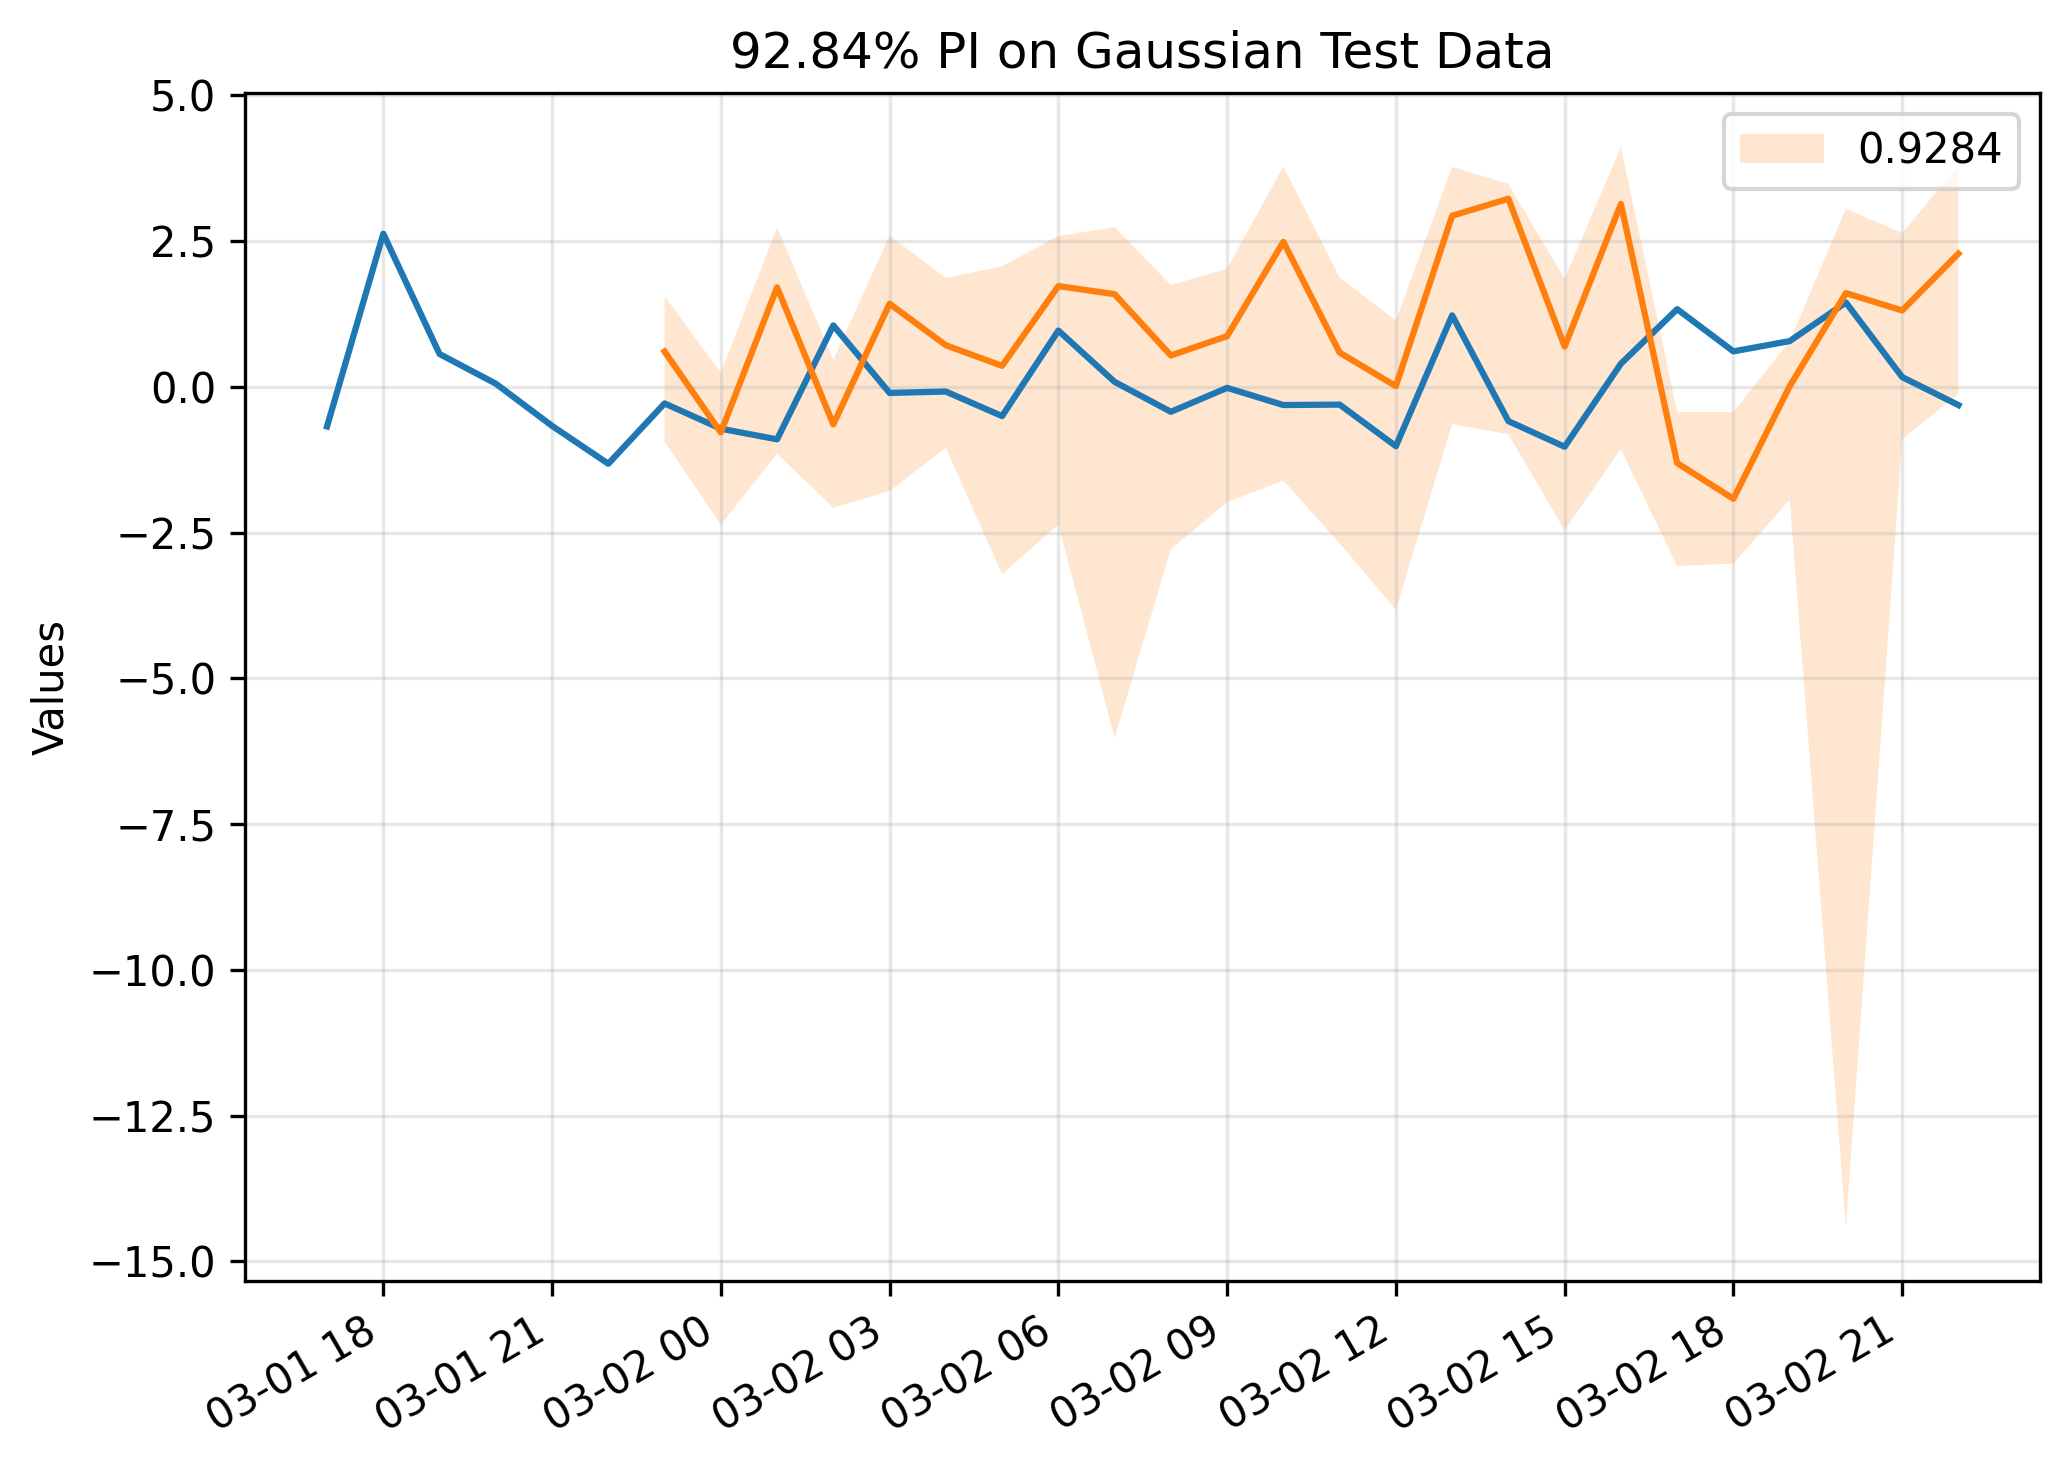

In [122]:
lq, uq = min(inter.keys()), max(inter.keys())
percentage_coverage = round((inter[uq] - inter[lq]),4)
p_str = str(percentage_coverage  * 100)+'%'
lb = test_it[0].quantile_ts(lq)
up = test_it[0].quantile_ts(uq)
dates = lb.index.to_timestamp().tolist()
fig, ax = plt.subplots(dpi=300)
ax.plot(tss[0][-30:].to_timestamp())
test_it[0].plot(intervals=[percentage_coverage ],show_label=True)
# ax.fill_between(dates, lb, up, color='lightgreen', alpha=0.4, label=p_str)
plt.title(f"{p_str} PI on Gaussian Test Data")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

In [121]:
difference = up - lb

# Calculate the mean and standard deviation of the difference
mean_diff = np.mean(difference)
std_diff = np.std(difference)

mean_diff, std_diff

(8.7834015, 7.3677416)

## Brownian Motion

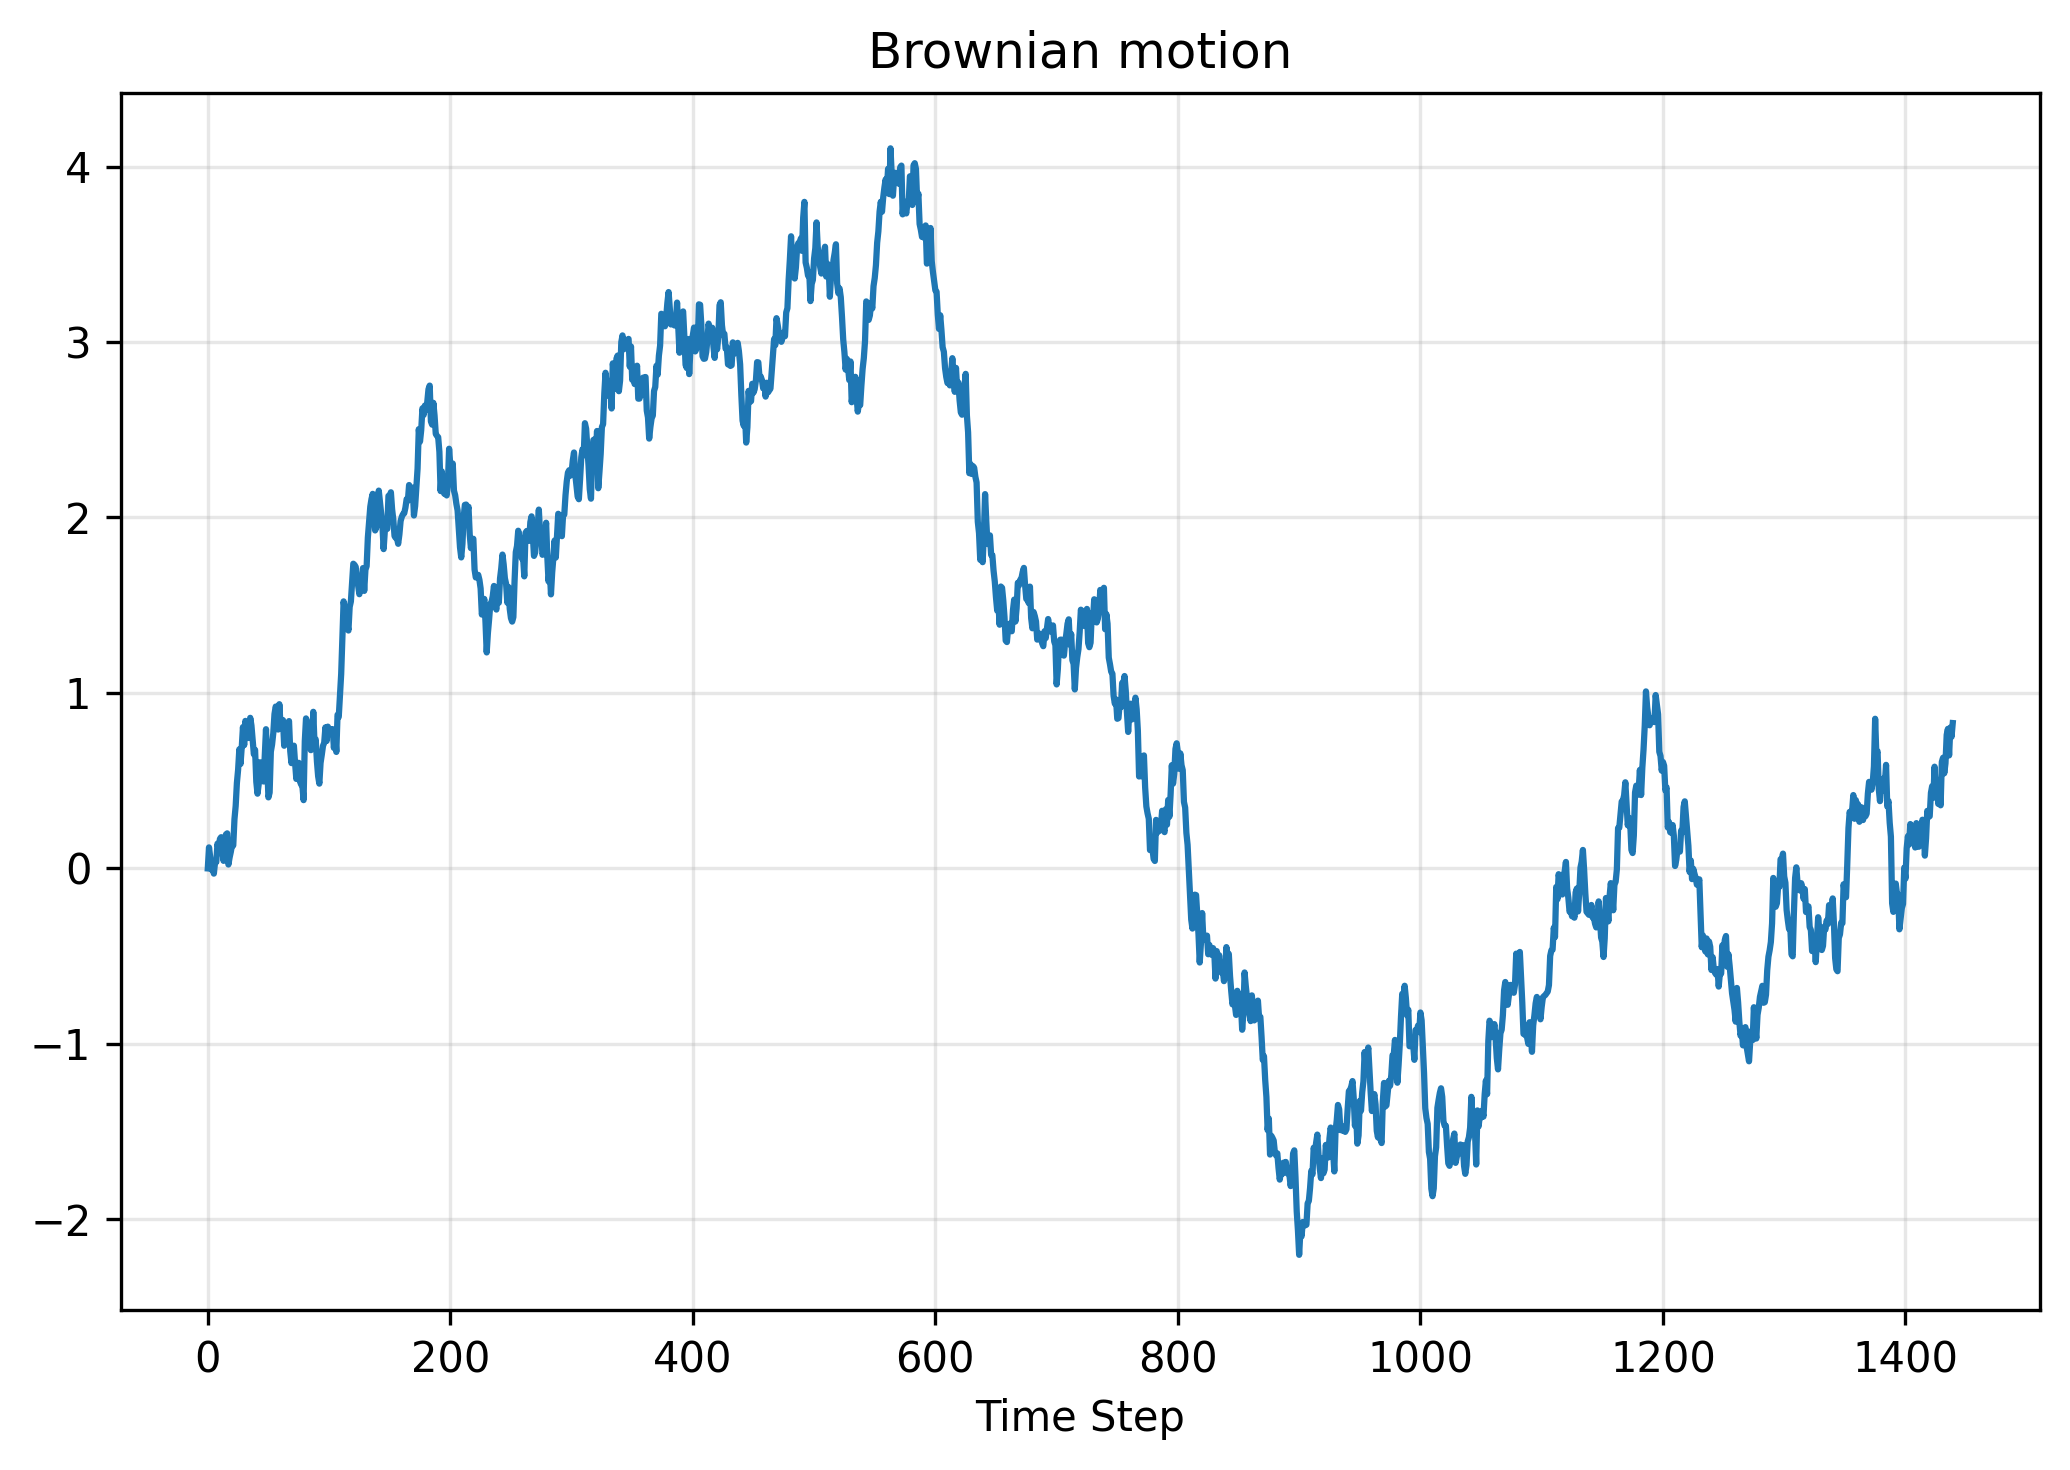

In [54]:
N = 1  # Number of time series
T = 24 * 60  # Number of timesteps (assuming hourly data for 30 days)
freq = "H"
std_dev = 0.1  # Standard deviation for the increments

# Initialize the dataset
bm_dataset = np.zeros((N, T))

# Generate Brownian motion
for i in range(1, T):
    bm_dataset[:, i] = bm_dataset[:, i - 1] + np.random.normal(0, std_dev, N)

start = pd.Period("01-01-2023", freq=freq)

fig, ax = plt.subplots(dpi=300)
ax.plot(bm_dataset[0])
plt.grid(alpha=0.3)
plt.xlabel("Time Step")
plt.title("Brownian motion")
plt.tight_layout()

In [55]:
# train and calibrate on the last 24 of train
prediction_length = 24
train_bm = bm_dataset[:,:-prediction_length]
# train dataset
train_bm_ds = ListDataset(
    [{"target": x, "start": start} for x in train_bm[:, :-prediction_length]],
    freq=freq,
)
# calibration dataset
calib_bm_ds = ListDataset(
    [{"target": x, "start": start} for x in train_bm], freq=freq
)

In [56]:
isqf_output = ISQFOutput(
    num_pieces=5,
    qk_x=[0.1, 0.3, 0.5, 0.7, 0.9]
)

# gaussian_output = GaussianOutput()
mqcnn_estimator = MQCNNEstimator(
    freq = 'H',
    prediction_length=prediction_length,
    distr_output=isqf_output,
    trainer = Trainer(epochs=20)
)

In [57]:
bm_predictor = mqcnn_estimator.train(train_bm_ds)

100%|██████████| 50/50 [01:49<00:00,  2.20s/it, epoch=20/20, avg_epoch_loss=0.00825]


In [58]:
calibrate_it, ts_it = make_evaluation_predictions(
    dataset=calib_bm_ds,  # calibration dataset
    predictor=bm_predictor,  # predictor
)
calibrate_it = list(calibrate_it)
tss = list(ts_it)

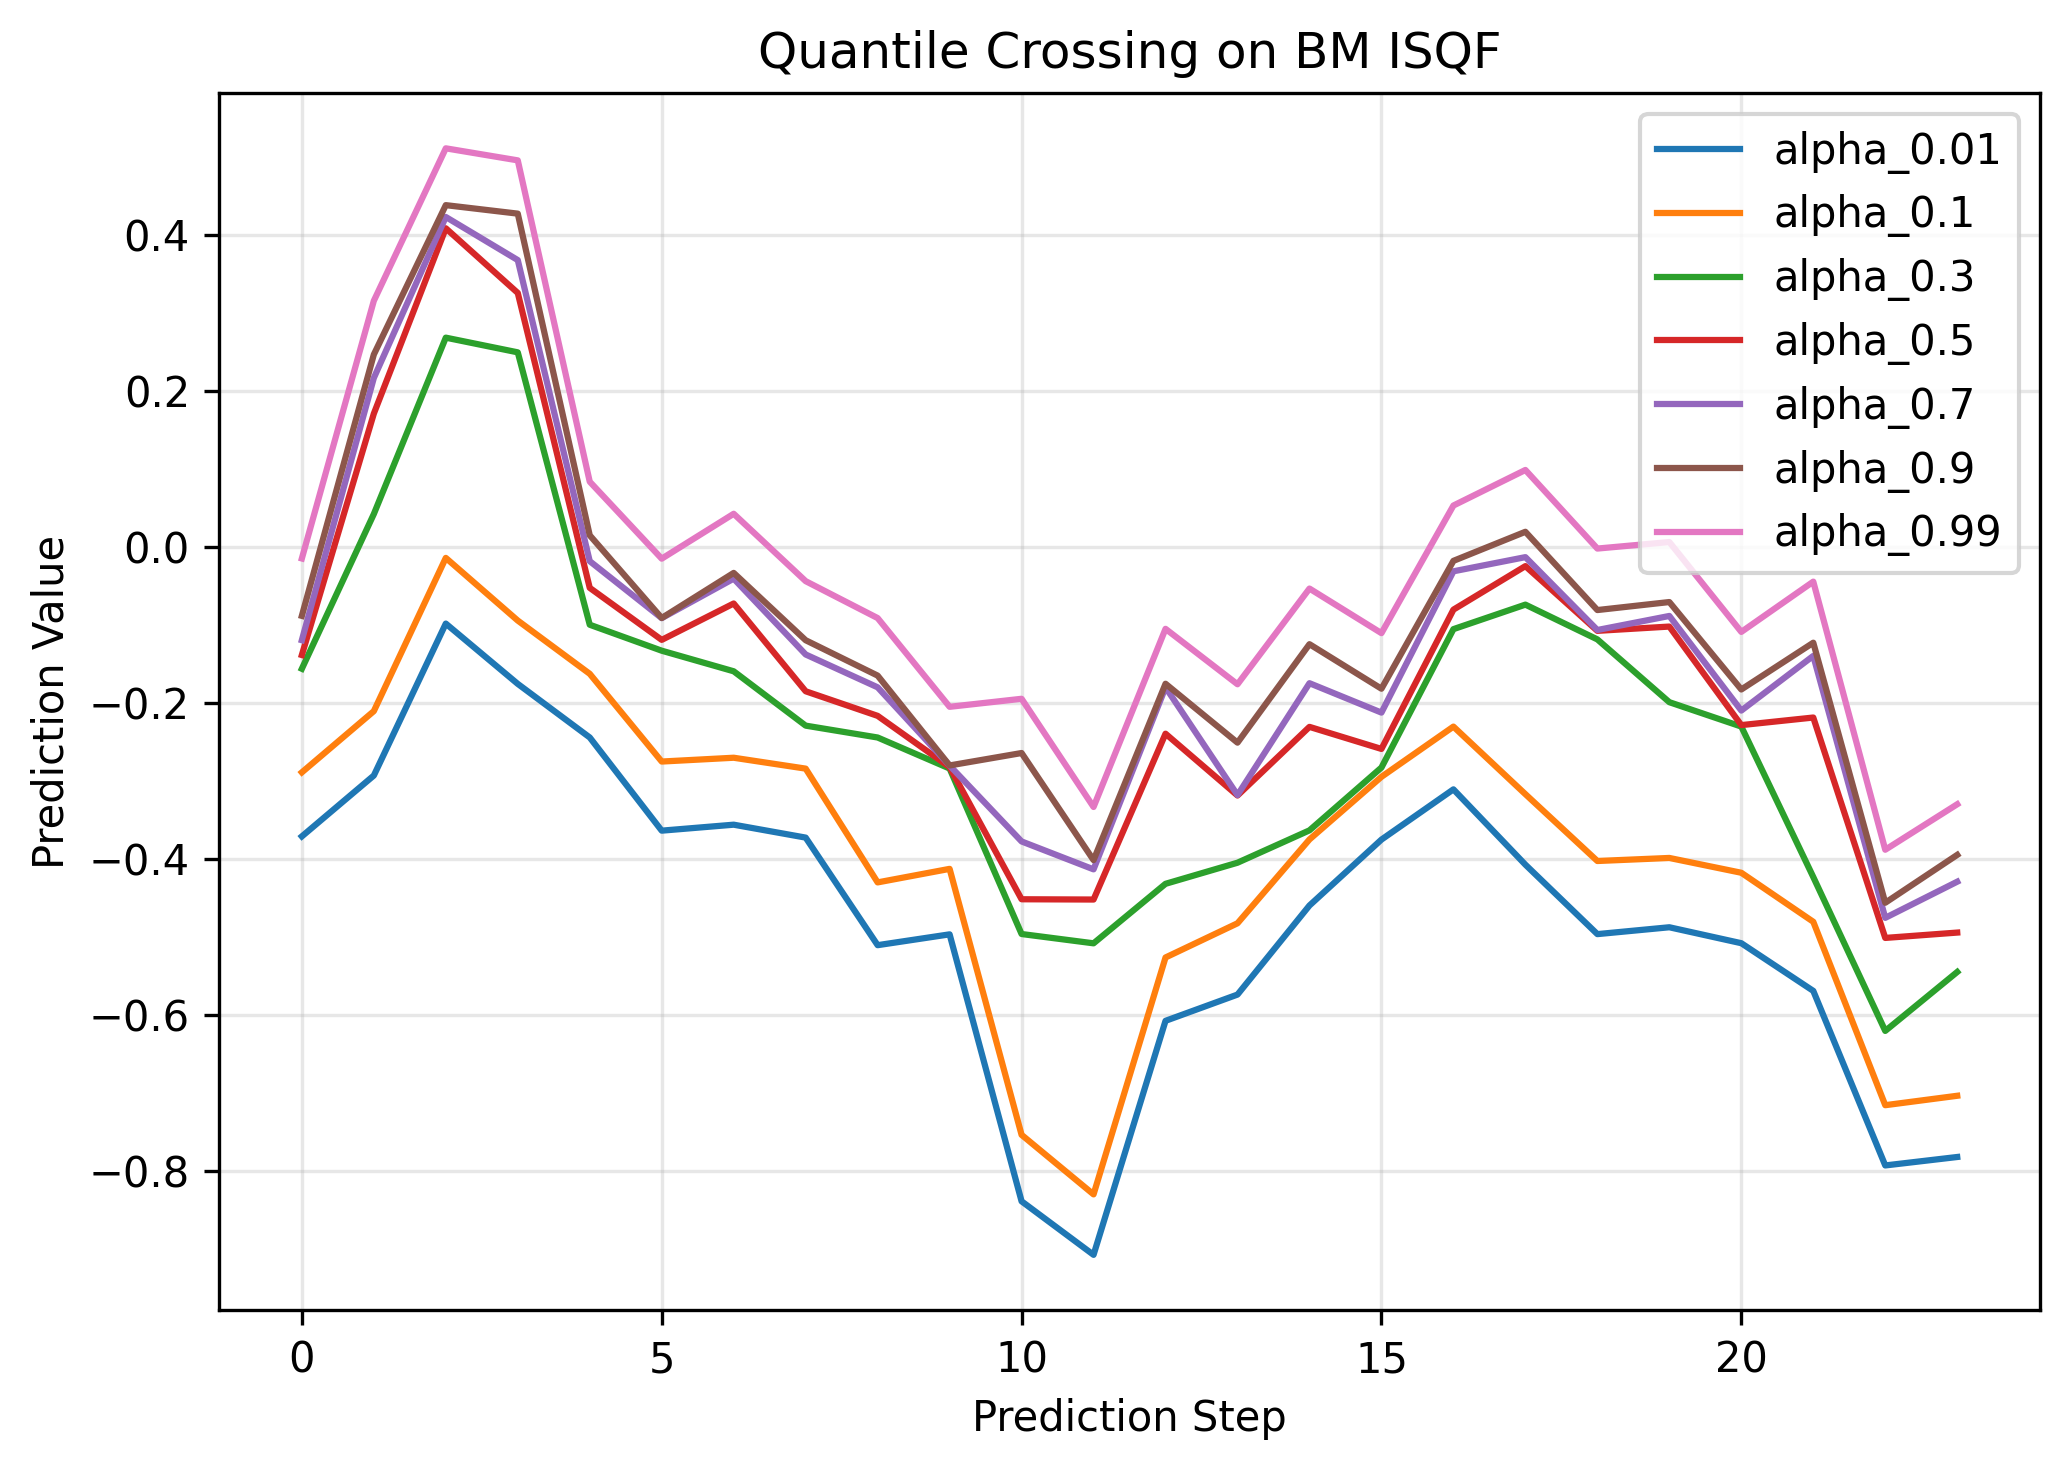

In [60]:
quantiles = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
calib_quantiles_df = pd.DataFrame({
    f'alpha_{q}': calibrate_it[0].quantile(q) for q in quantiles
})

fig, ax = plt.subplots(dpi=300)

for c in calib_quantiles_df.columns:
  ax.plot(calib_quantiles_df.loc[:,c], label=c)

plt.ylabel('Prediction Value')
plt.xlabel('Prediction Step')
plt.title('Quantile Crossing on BM ISQF')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()


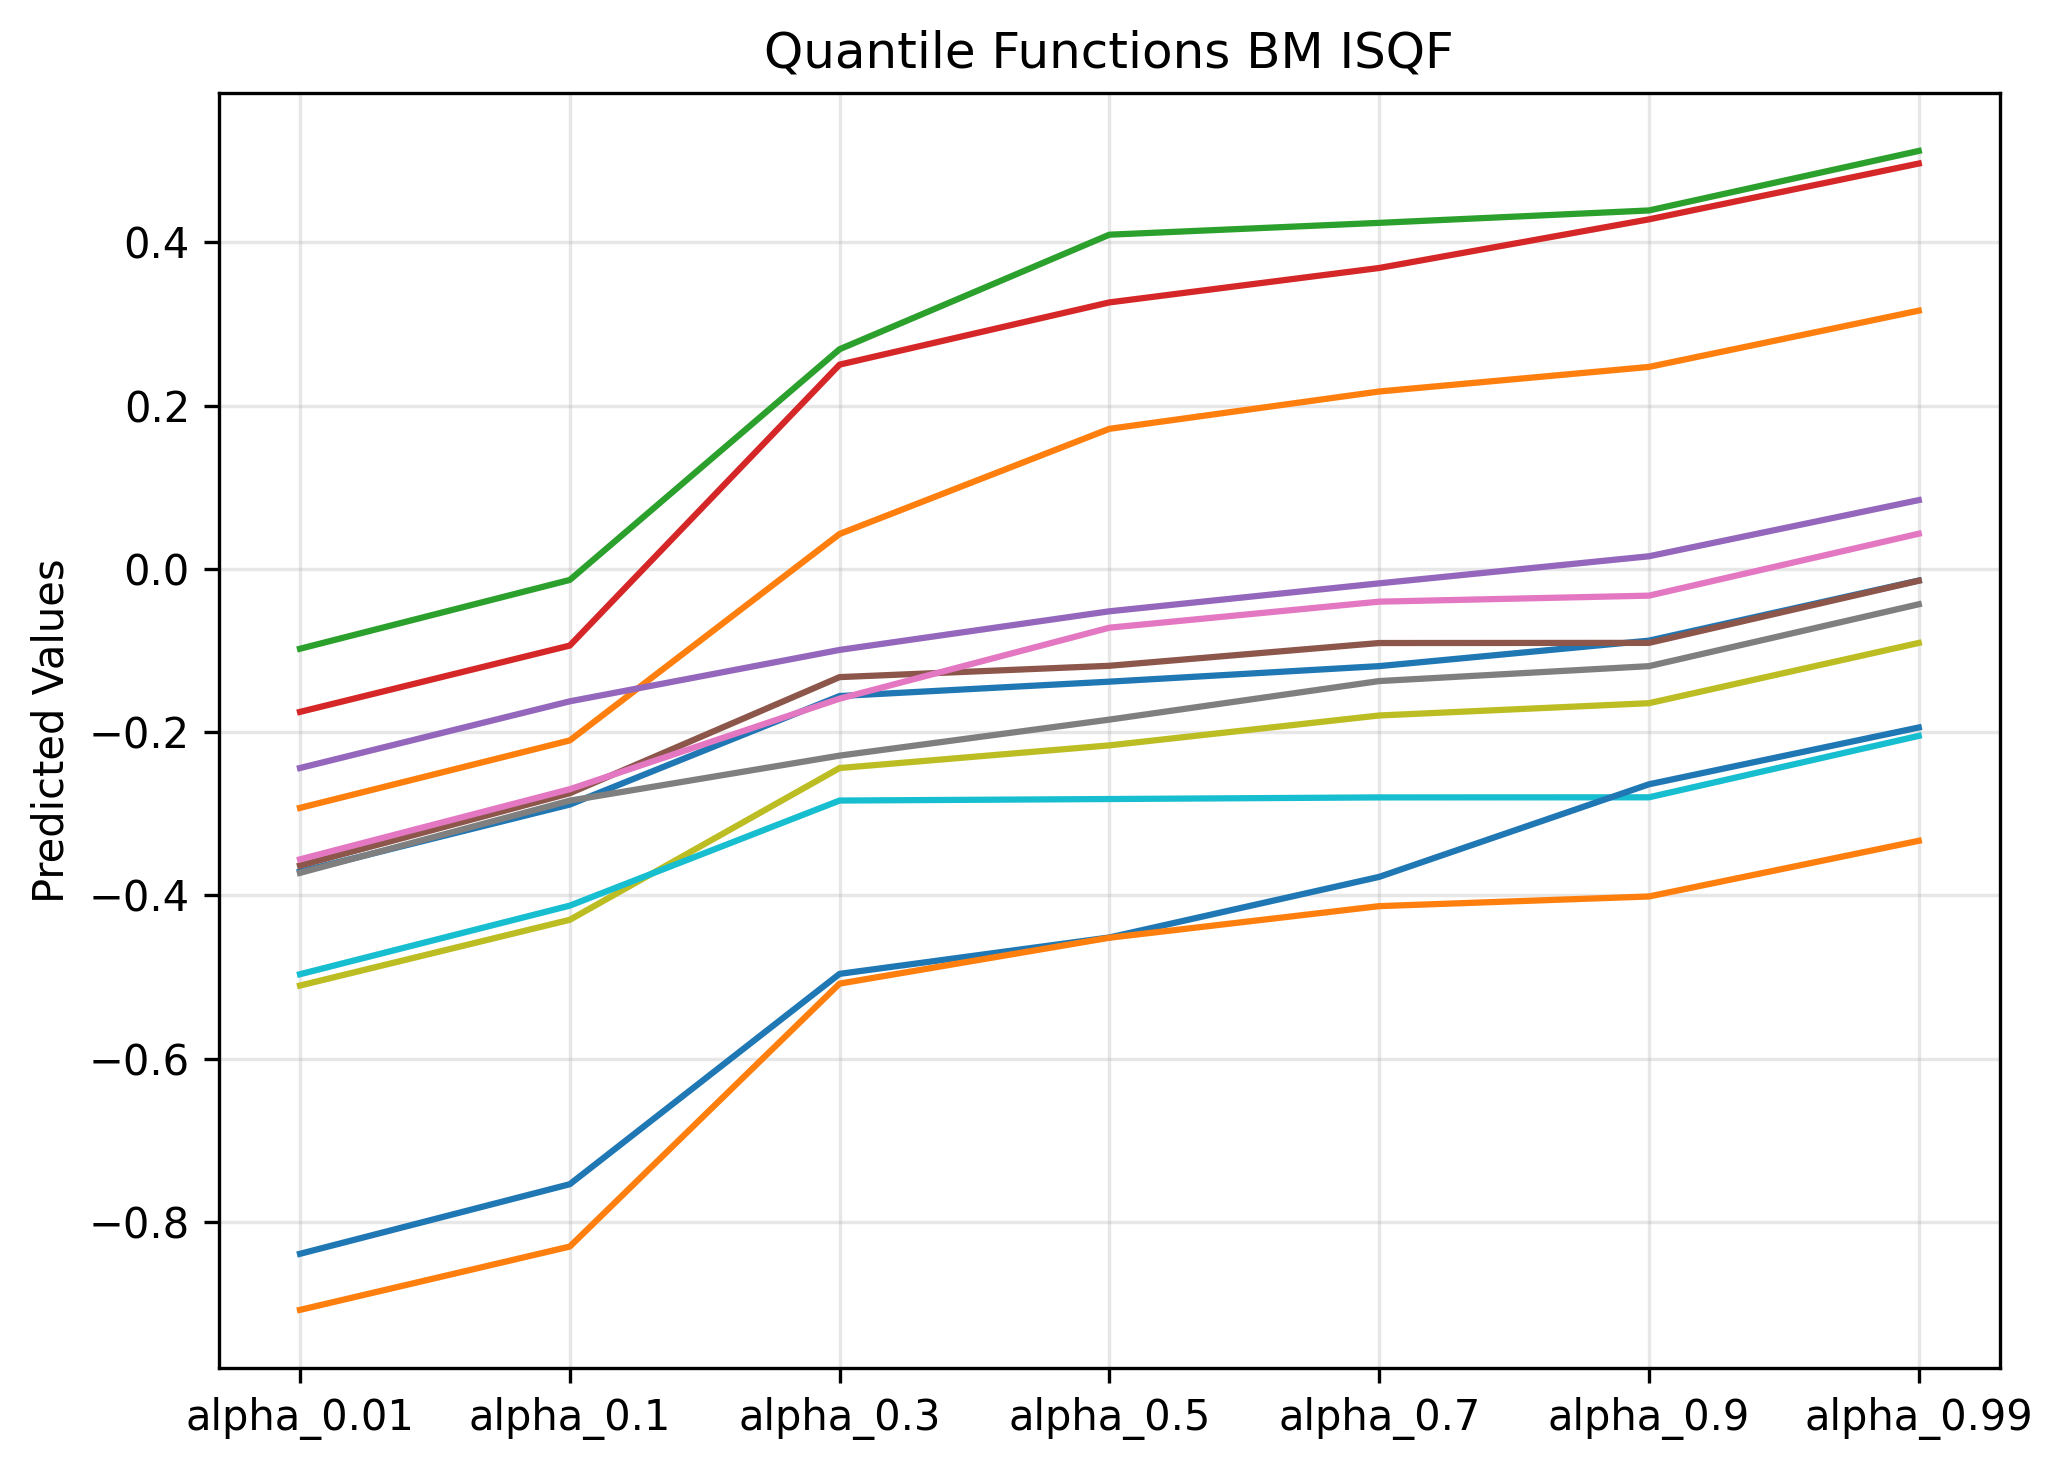

In [61]:
# Plot some quantile functions
fig, ax = plt.subplots(dpi=300)
for r in range(12):
  ax.plot(calib_quantiles_df.iloc[r])

plt.ylabel('Predicted Values')
plt.title('Quantile Functions BM ISQF')
plt.grid(alpha=0.3)
plt.tight_layout()

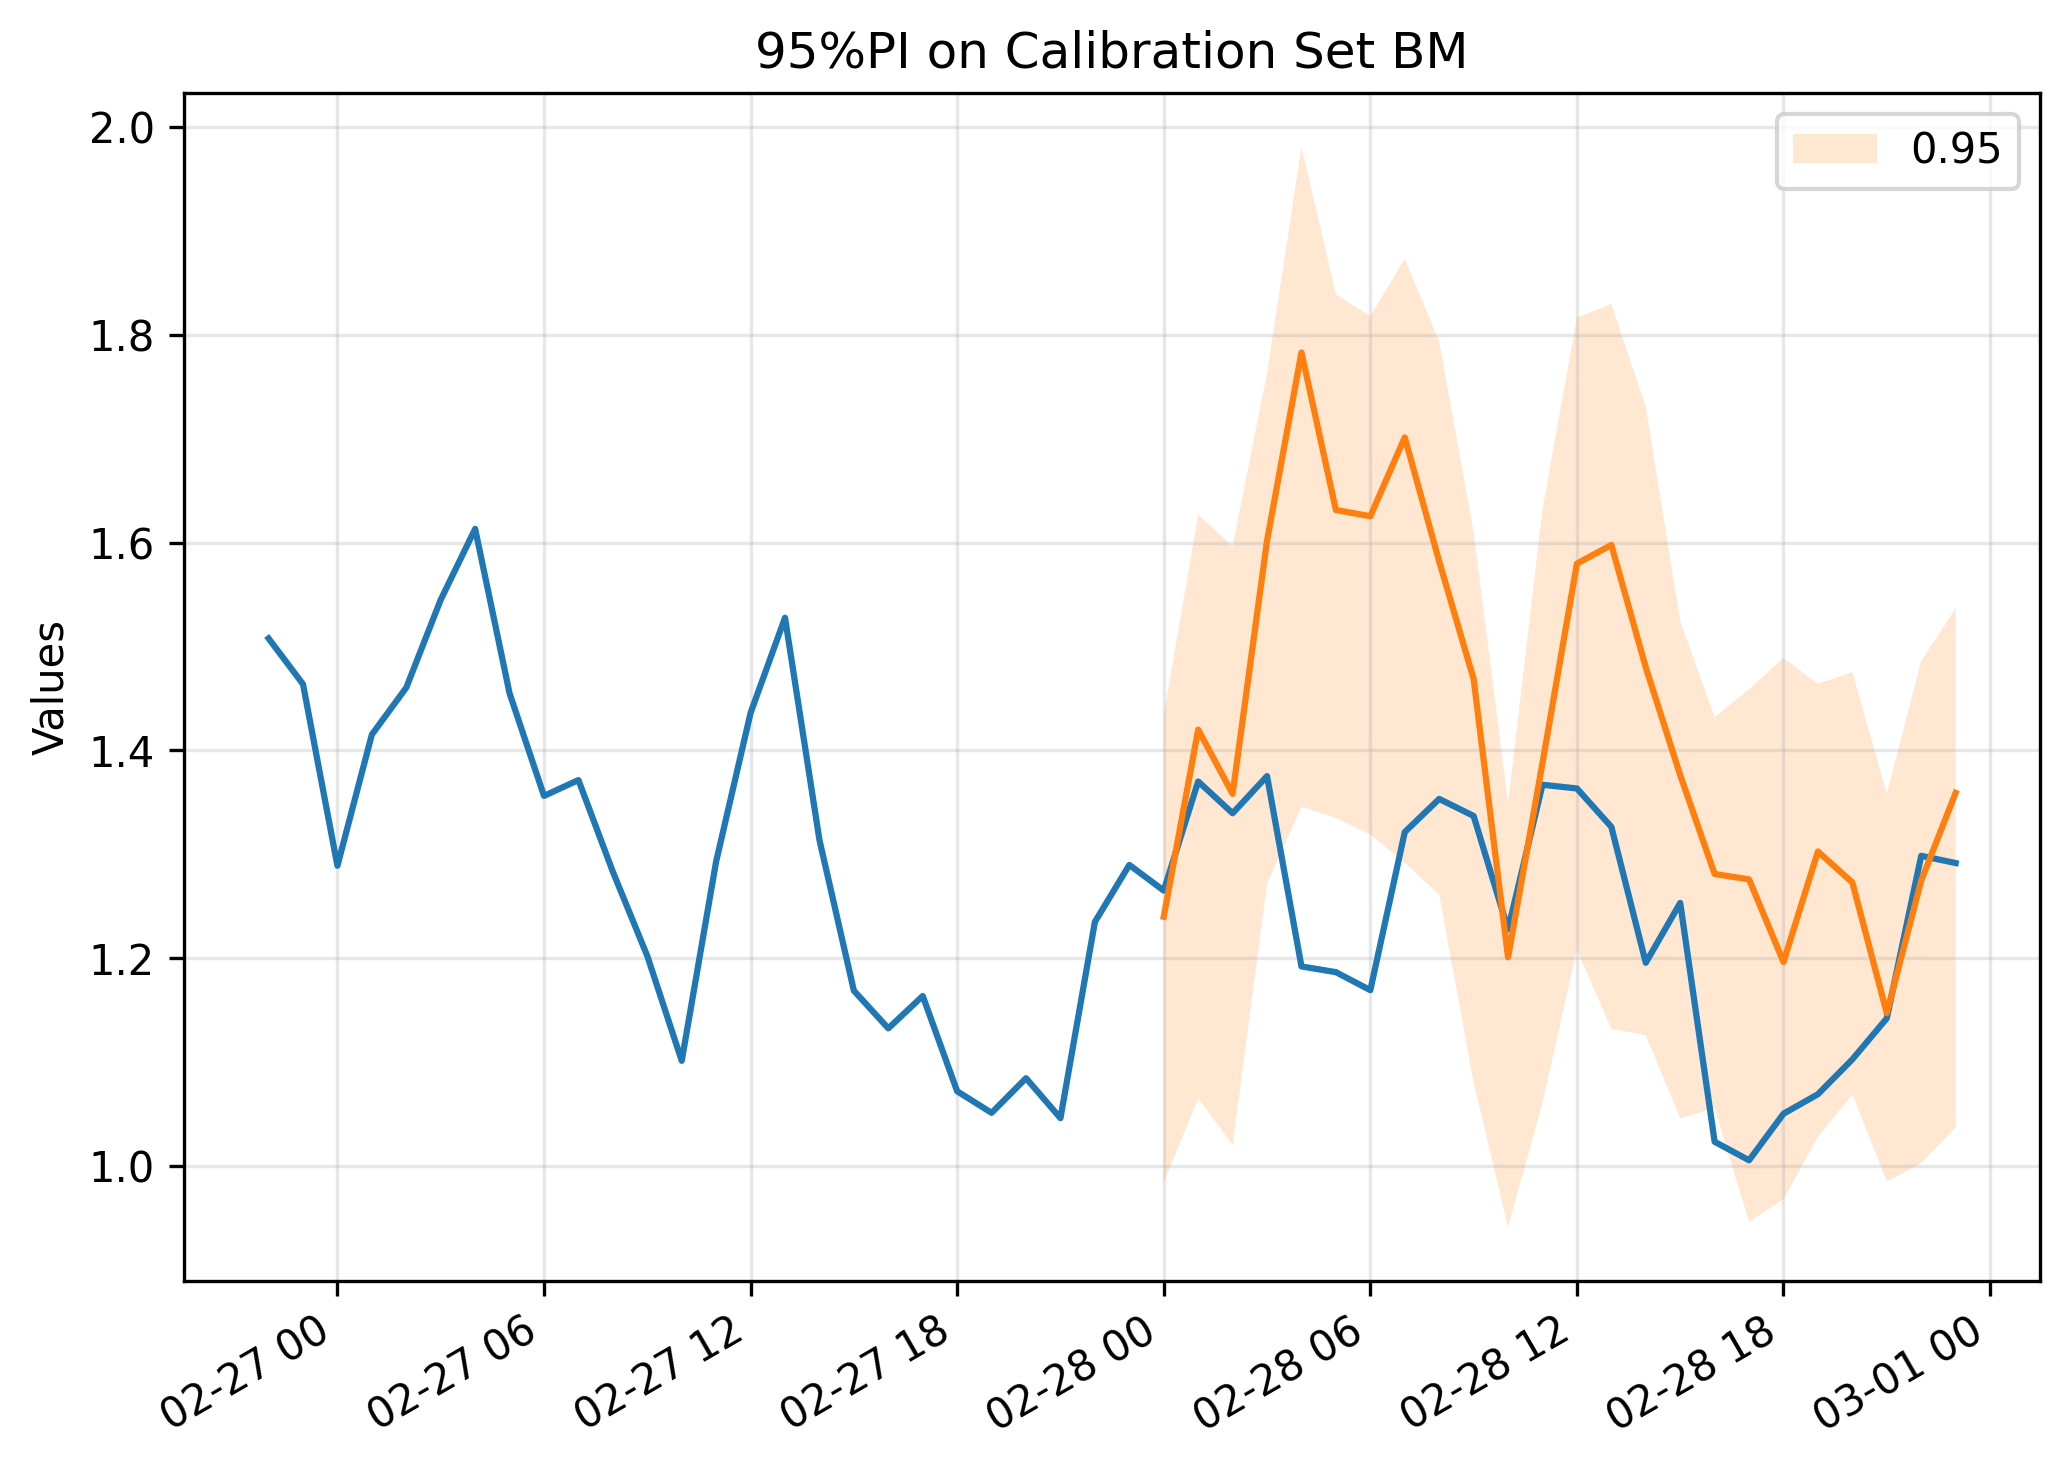

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.plot(tss[0][-50:].to_timestamp())
calibrate_it[0].plot(intervals=[0.95],show_label=True)
plt.title("95%PI on Calibration Set BM")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

In [62]:
calib_set = []
valid_ds = tss[0][-24:][0]
valid_idx = valid_ds.index
for date, y in zip(valid_idx, valid_ds.values):
  q_hat = binary_search_for_alpha(y, date, calibrate_it[0])
  calib_set.append(q_hat)
calib_set.sort()

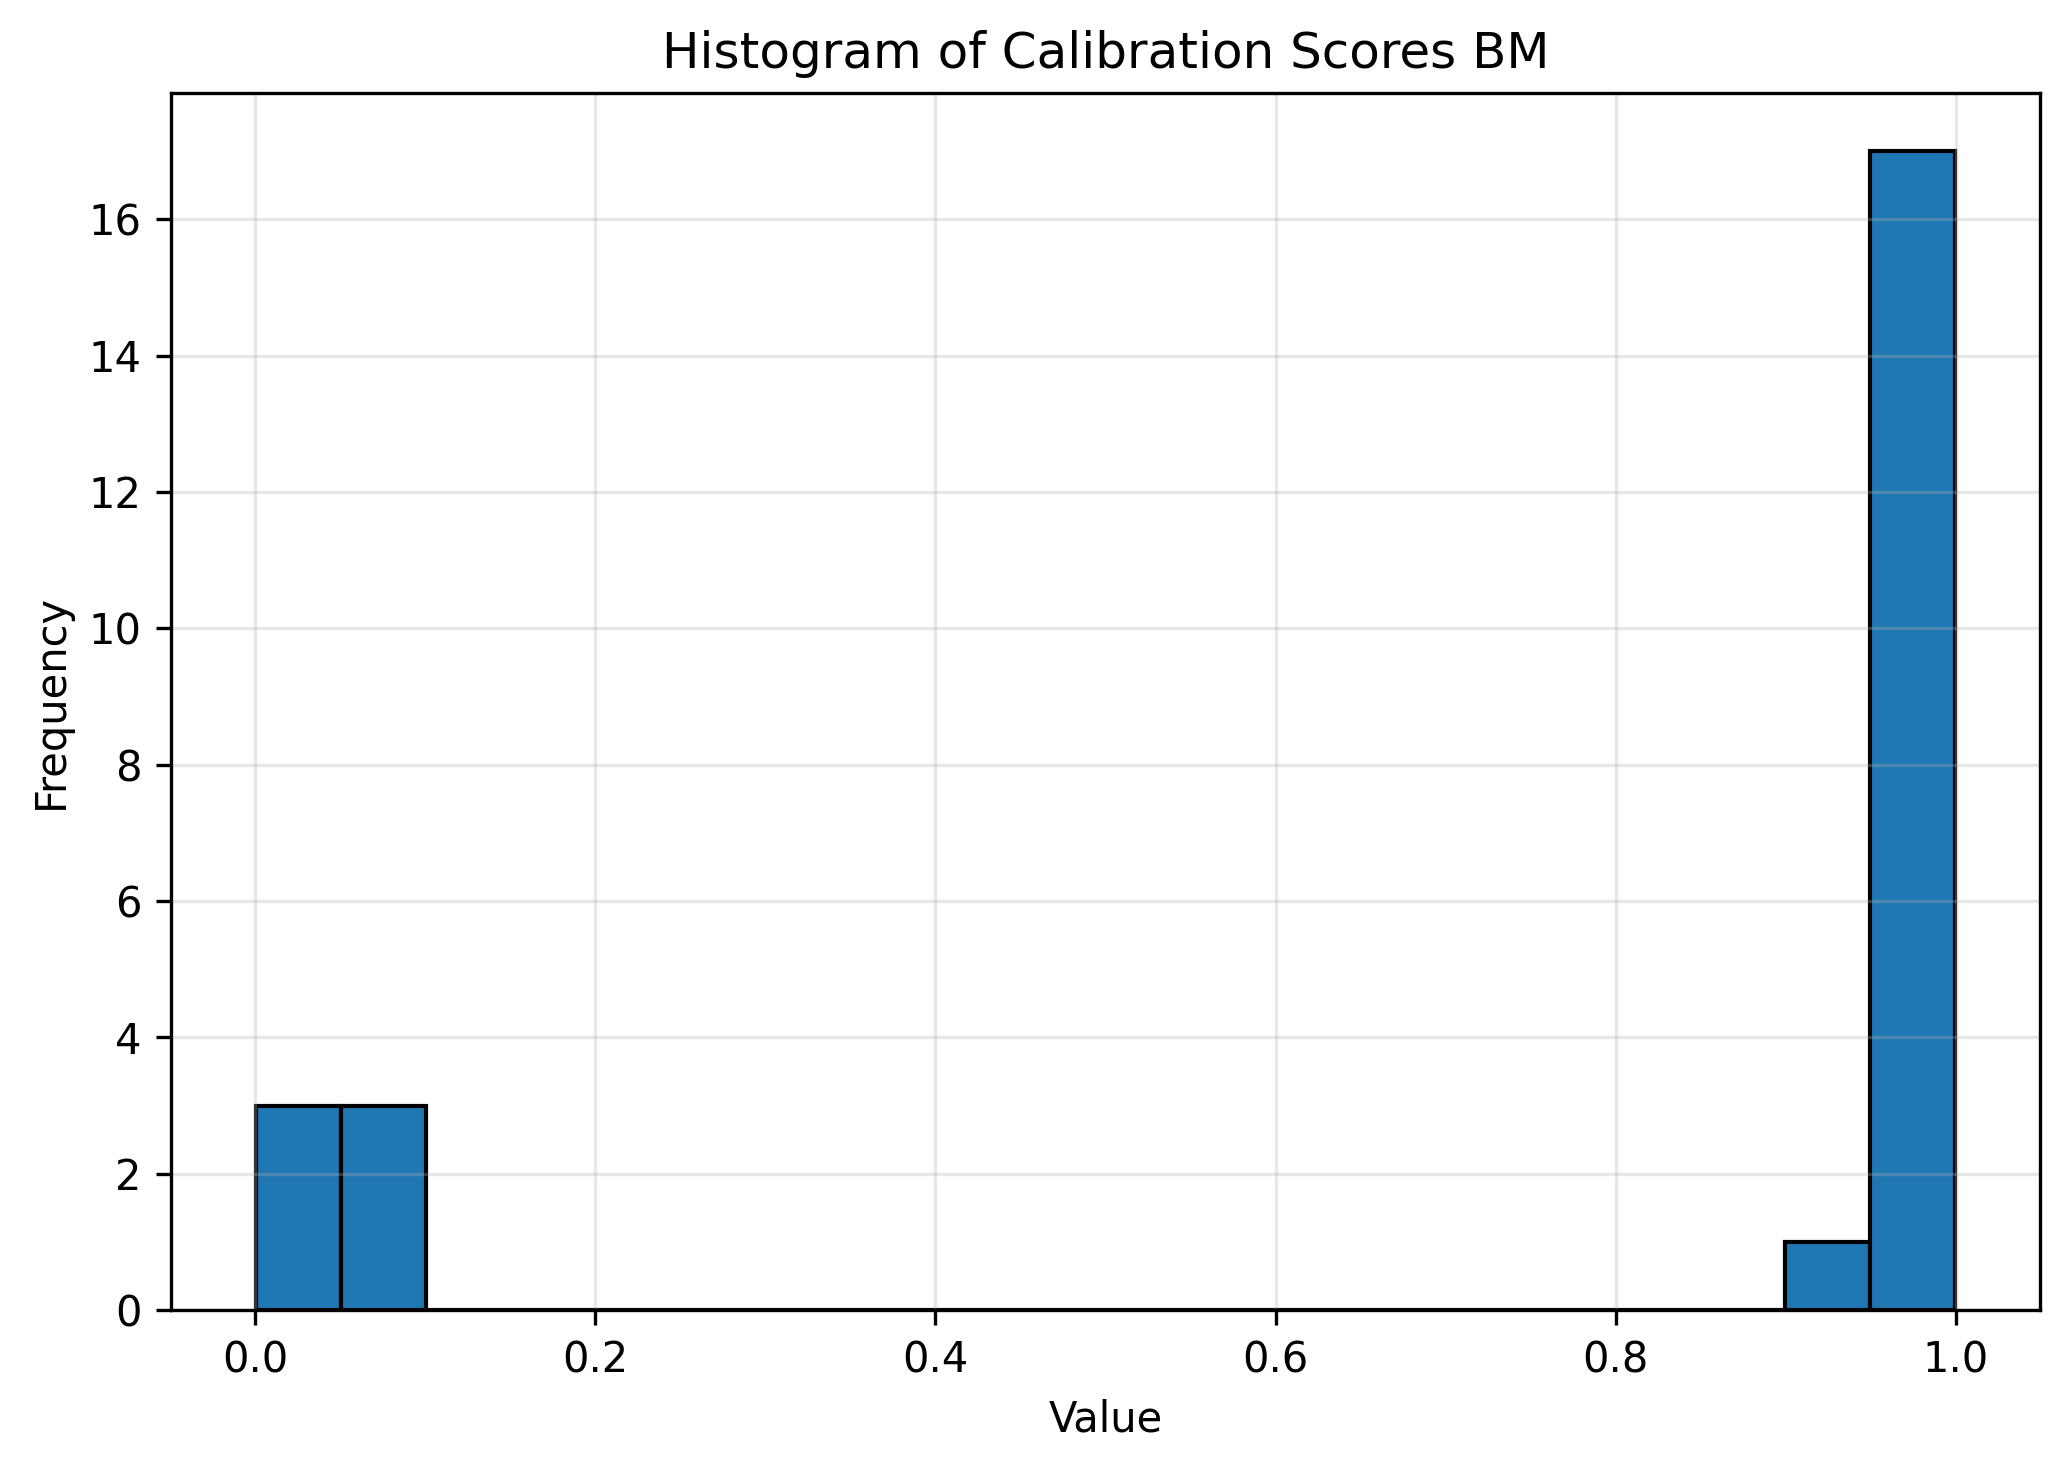

In [63]:
fig, ax = plt.subplots(dpi=300)
ax.hist(calib_set, bins=20, edgecolor='black')
ax.set_title('Histogram of Calibration Scores BM')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()

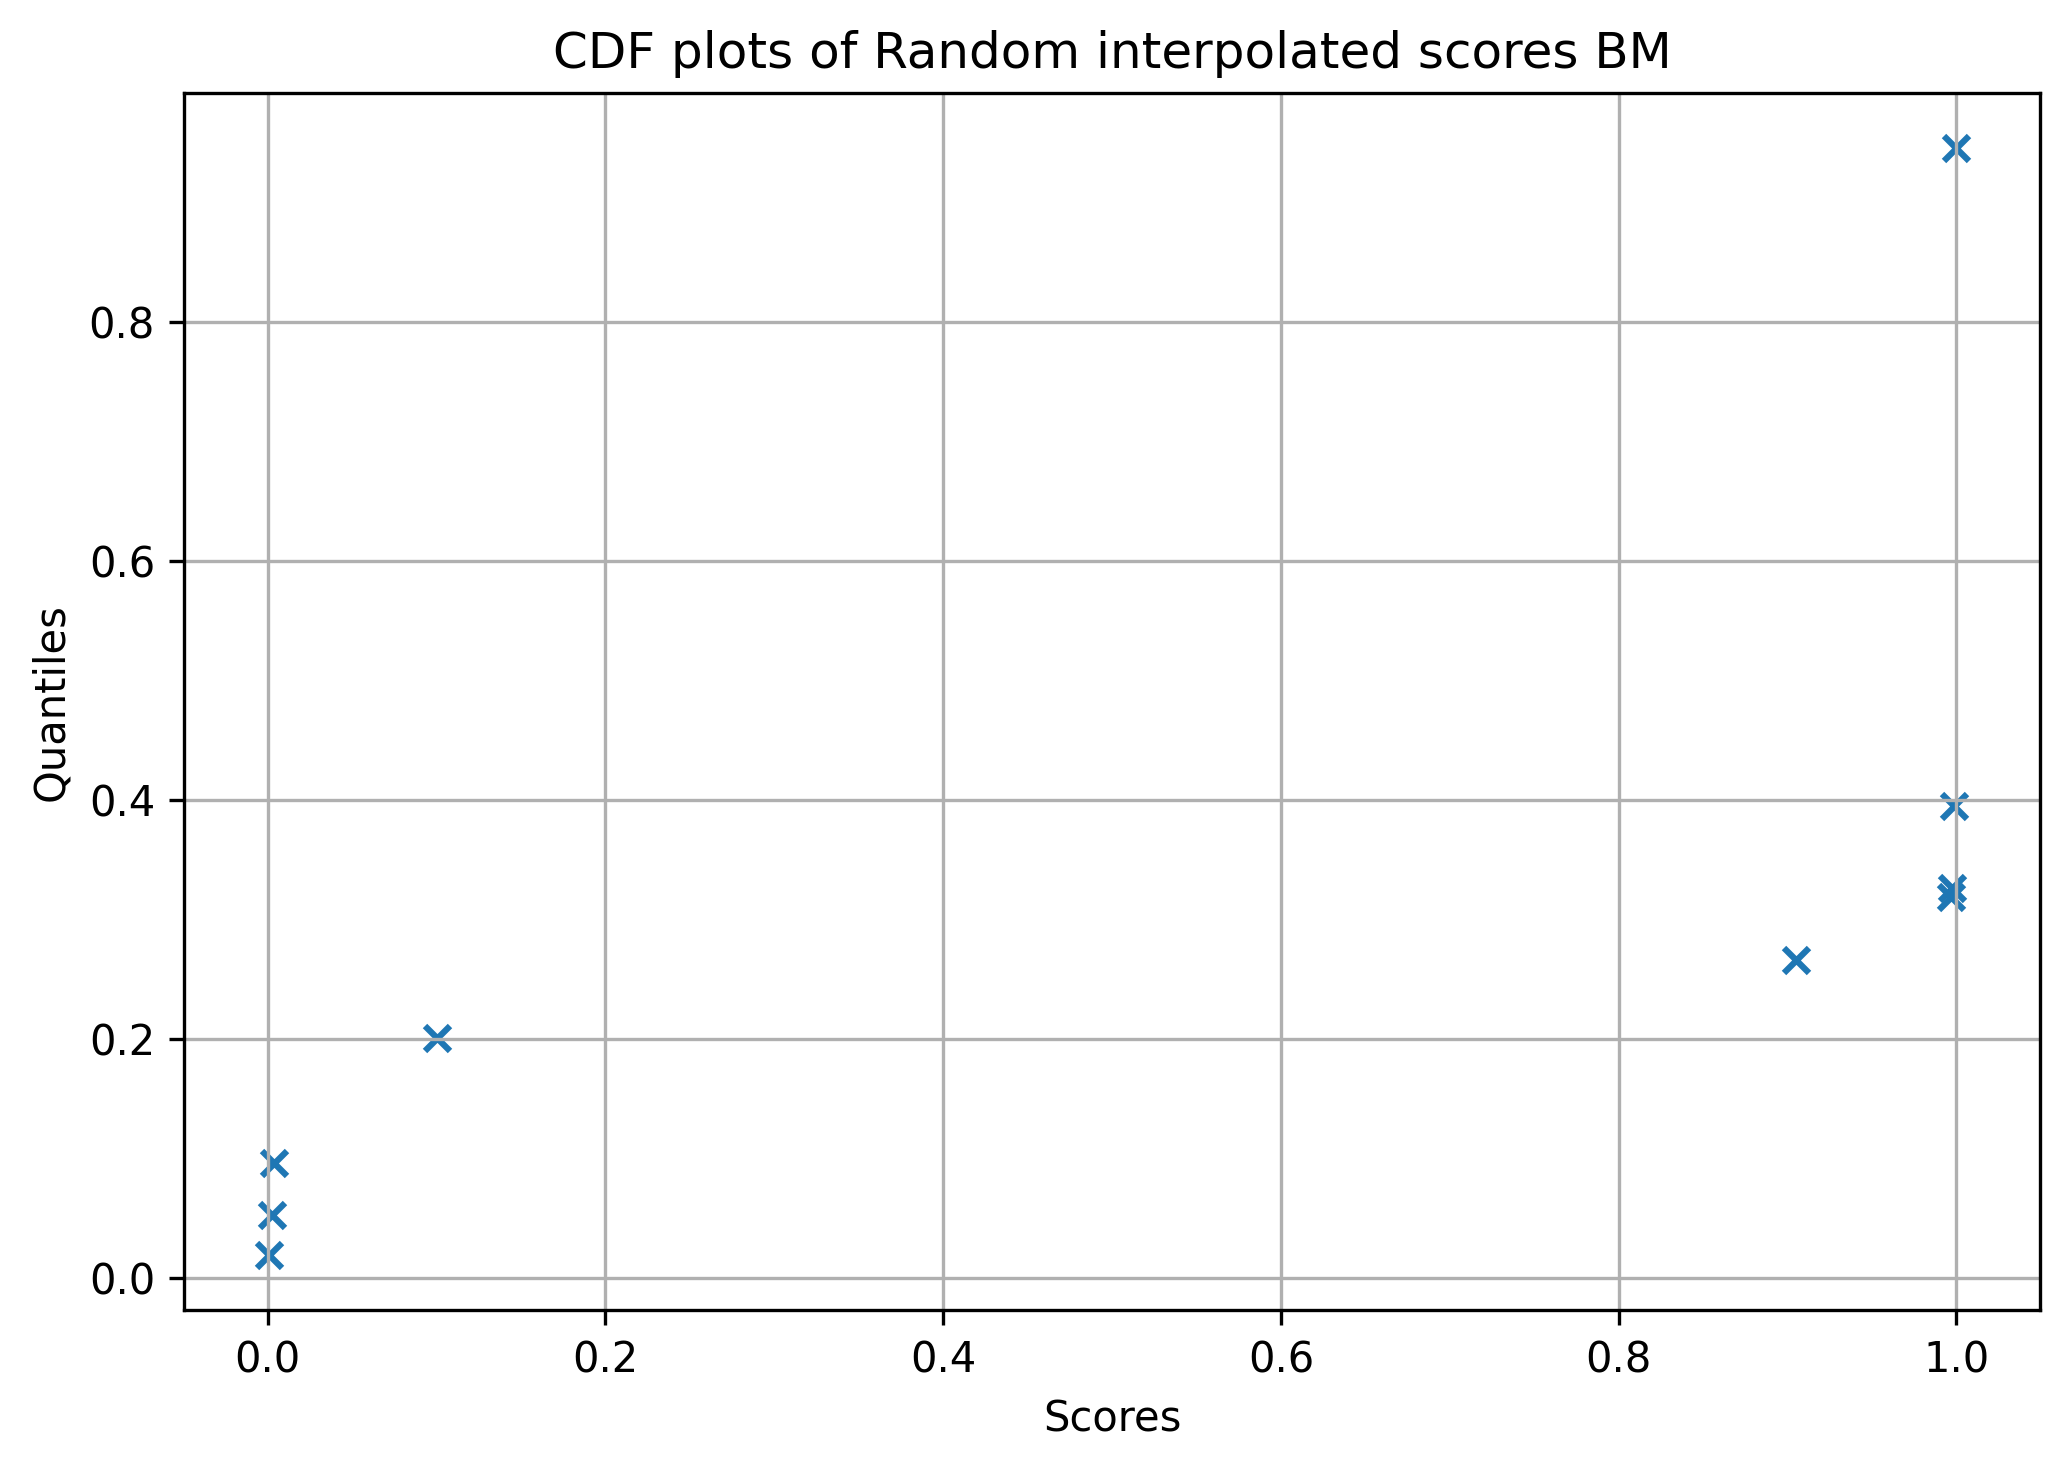

In [64]:
inter = interpolation_random(calib_set)
fig, ax = plt.subplots(dpi=300)
ax.scatter(inter.keys(), inter.values(), marker='x')
plt.title('CDF plots of Random interpolated scores BM')
plt.xlabel('Scores')
plt.ylabel('Quantiles')
plt.grid(True)
plt.tight_layout()

In [65]:
test_bm_ds = ListDataset(
    [{"target": x, "start": start} for x in bm_dataset], freq=freq
)
test_it, ts_it = make_evaluation_predictions(
    dataset=test_bm_ds,  # calibration dataset
    predictor=bm_predictor,  # predictor
)

test_it = list(test_it)
tss = list(ts_it)

In [66]:
inter

{0.00048828125: 0.019641646194070196,
 0.00244140625: 0.052851464794133635,
 0.00341796875: 0.09625227277685128,
 0.10009765625: 0.2010386603418437,
 0.90478515625: 0.2665310096843307,
 0.99658203125: 0.319168601122992,
 0.99755859375: 0.3262916507202064,
 0.99853515625: 0.3951872984250261,
 0.99951171875: 0.9455482830465436}

In [72]:
lq, uq = min(inter.keys()), max(inter.keys())
percentage_coverage = round((inter[uq] - inter[lq]),4)
percentage_coverage

0.9259

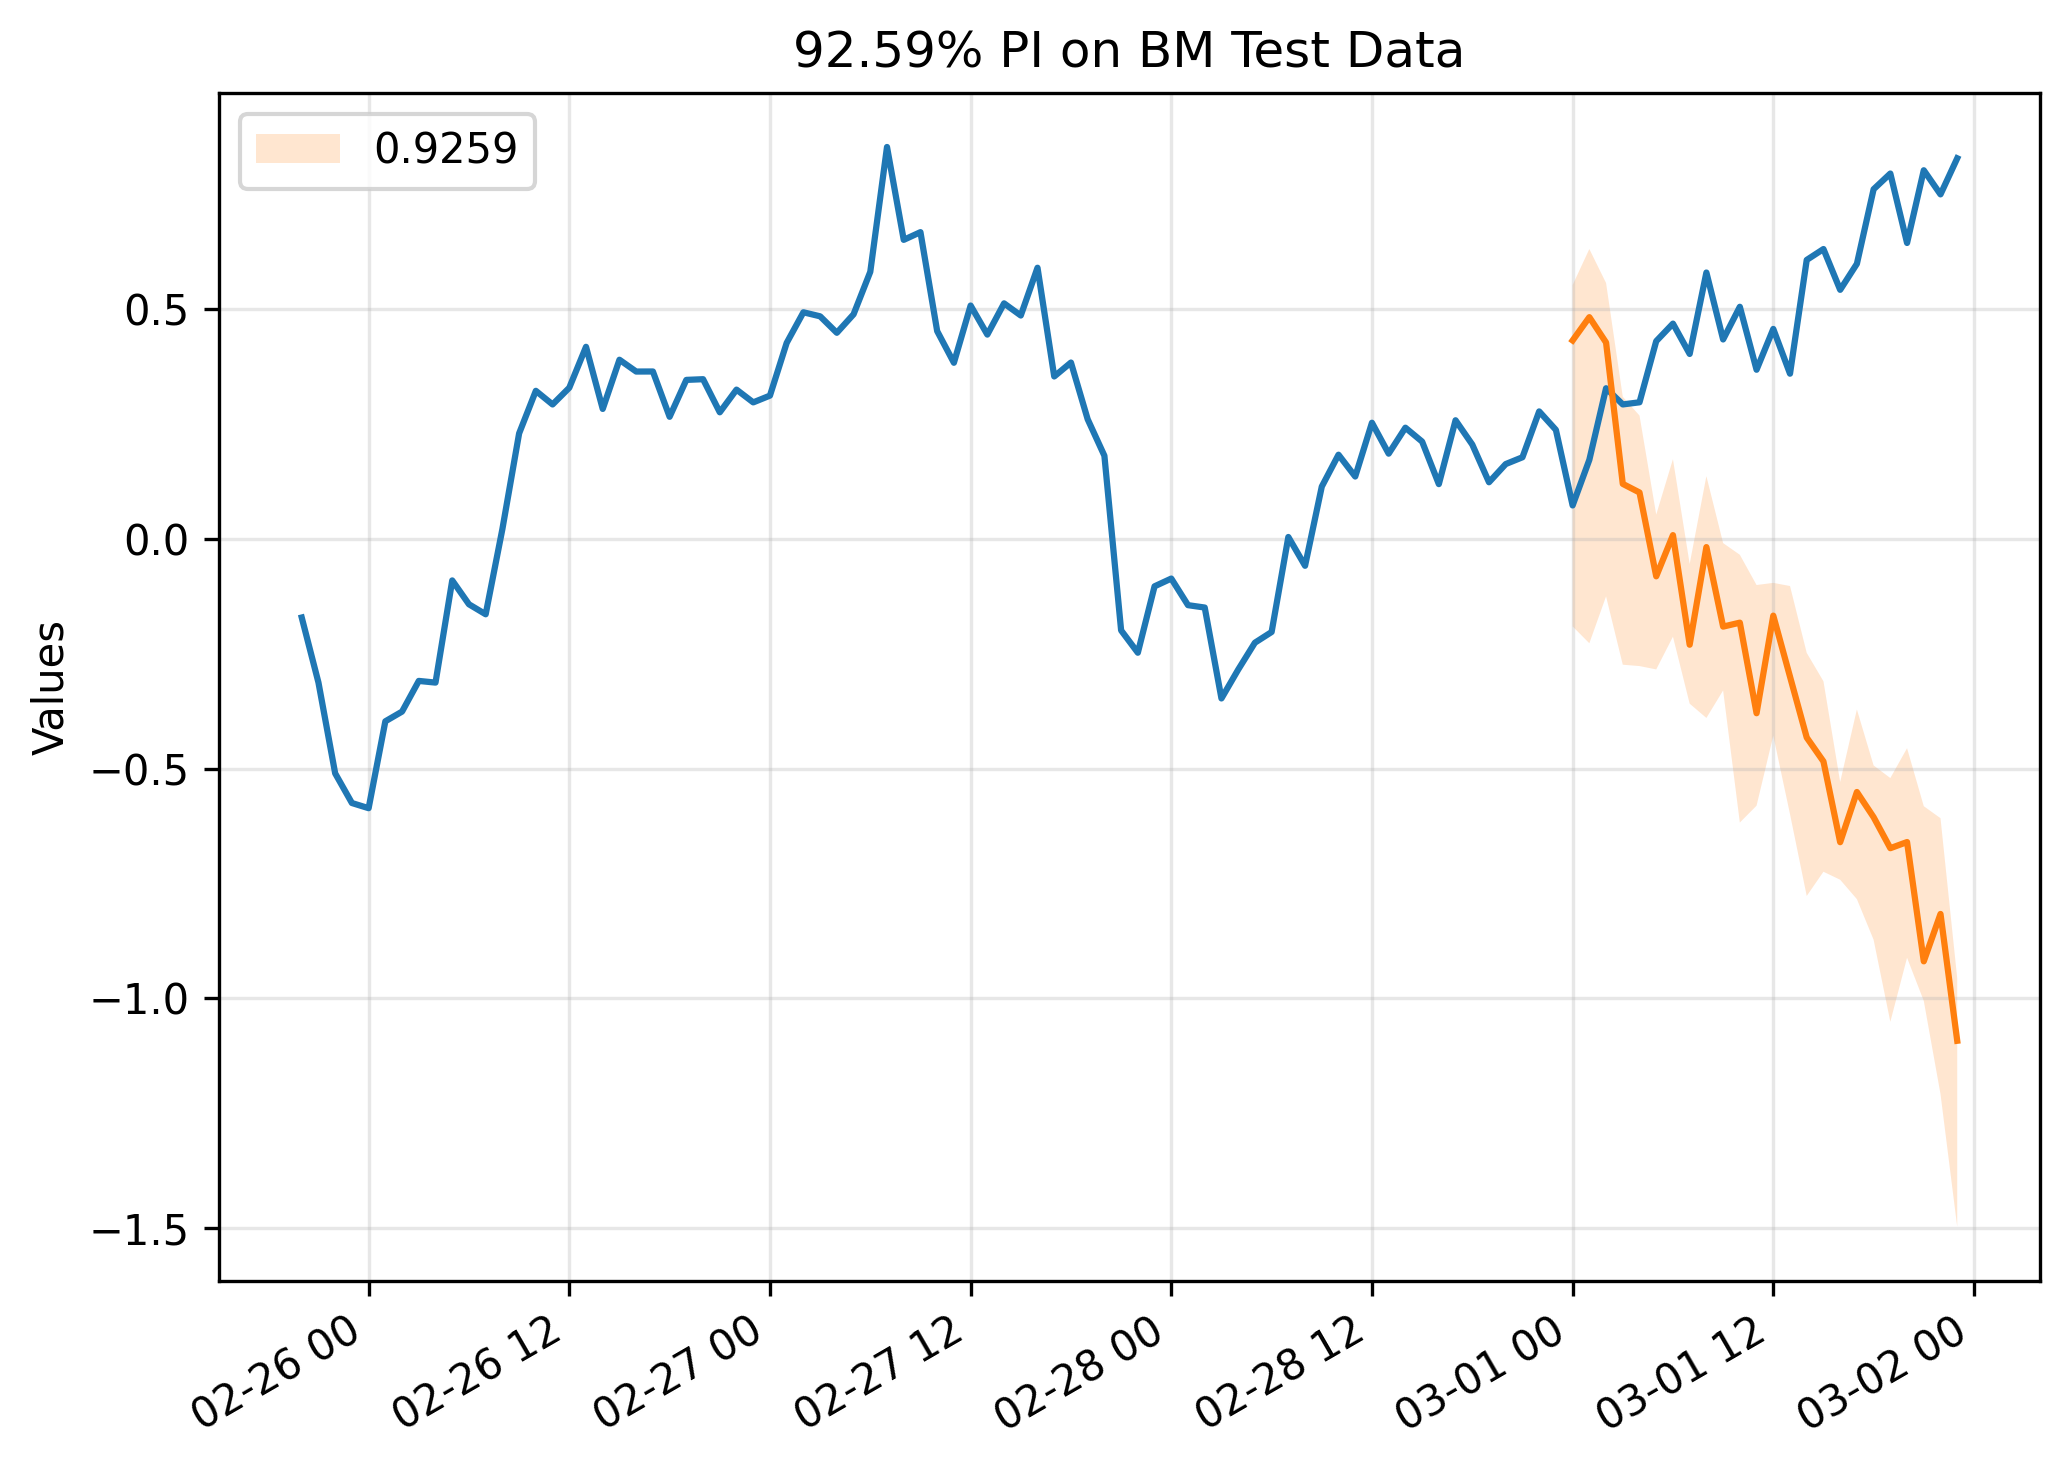

In [75]:
lq, uq = min(inter.keys()), max(inter.keys())
percentage_coverage = round((inter[uq] - inter[lq]),4)
p_str = str(percentage_coverage  * 100)+'%'
lb = test_it[0].quantile_ts(lq)
up = test_it[0].quantile_ts(uq)
dates = lb.index.to_timestamp().tolist()
fig, ax = plt.subplots(dpi=300)
ax.plot(tss[0][-100:].to_timestamp())
test_it[0].plot(intervals=[0.9259],show_label=True)
# ax.fill_between(dates, lb, up, color='lightgreen', alpha=0.4, label=p_str)
plt.title(f"{92.59}% PI on BM Test Data")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

## Real Time Series

In [76]:
# print(f"Available datasets: {dataset_names}")
dataset = get_dataset("m4_daily")

train_entry = next(iter(dataset.train))
m4_train_series = to_pandas(train_entry)
test_entry = next(iter(dataset.test))
m4_test_series = to_pandas(test_entry)


In [77]:
print(f"Length of forecasting window in test dataset: {len(m4_test_series) - len(m4_train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 14
Recommended prediction horizon: 14
Frequency of the time series: D


In [78]:
m4_test_series.to_frame()

0
1750-01-01  1017.099976
1750-01-02  1019.299988
1750-01-03  1017.000000
1750-01-04  1019.200012
1750-01-05  1018.700012
...                 ...
1752-10-12  2066.399902
1752-10-13  2067.399902
1752-10-14  2071.399902
1752-10-15  2083.800049
1752-10-16  2080.600098

[1020 rows x 1 columns]

from matplotlib import pyplot as plt
_df_0[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

In [80]:
start = pd.Period('1750-01-01', freq='D')

# train and calibrate on the last 24 of train
prediction_length = 14
train_dataset = train_dataset=m4_train_series.values.reshape(1, -1)
# train dataset
train_ds = ListDataset(
    [{"target": x, "start": start} for x in train_dataset[:, :-prediction_length]],
    freq='D',
)
# calibration dataset
calib_ds = ListDataset(
    [{"target": x, "start": start} for x in train_dataset], freq='D'
)

In [82]:
isqf_output = ISQFOutput(
    num_pieces=5,
    qk_x=[0.1, 0.3, 0.5, 0.7, 0.9]
)

mqcnn_estimator = MQCNNEstimator(
    freq = 'D',
    prediction_length=prediction_length,
    distr_output=isqf_output,
    trainer = Trainer(epochs=30)
)

In [83]:
m4_predictor = mqcnn_estimator.train(train_ds)

100%|██████████| 50/50 [00:38<00:00,  1.30it/s, epoch=30/30, avg_epoch_loss=21.4]


In [84]:
calibrate_it, ts_it = make_evaluation_predictions(
    dataset=calib_ds,  # calibration dataset
    predictor=m4_predictor,  # predictor
)
calibrate_it = list(calibrate_it)
tss = list(ts_it)

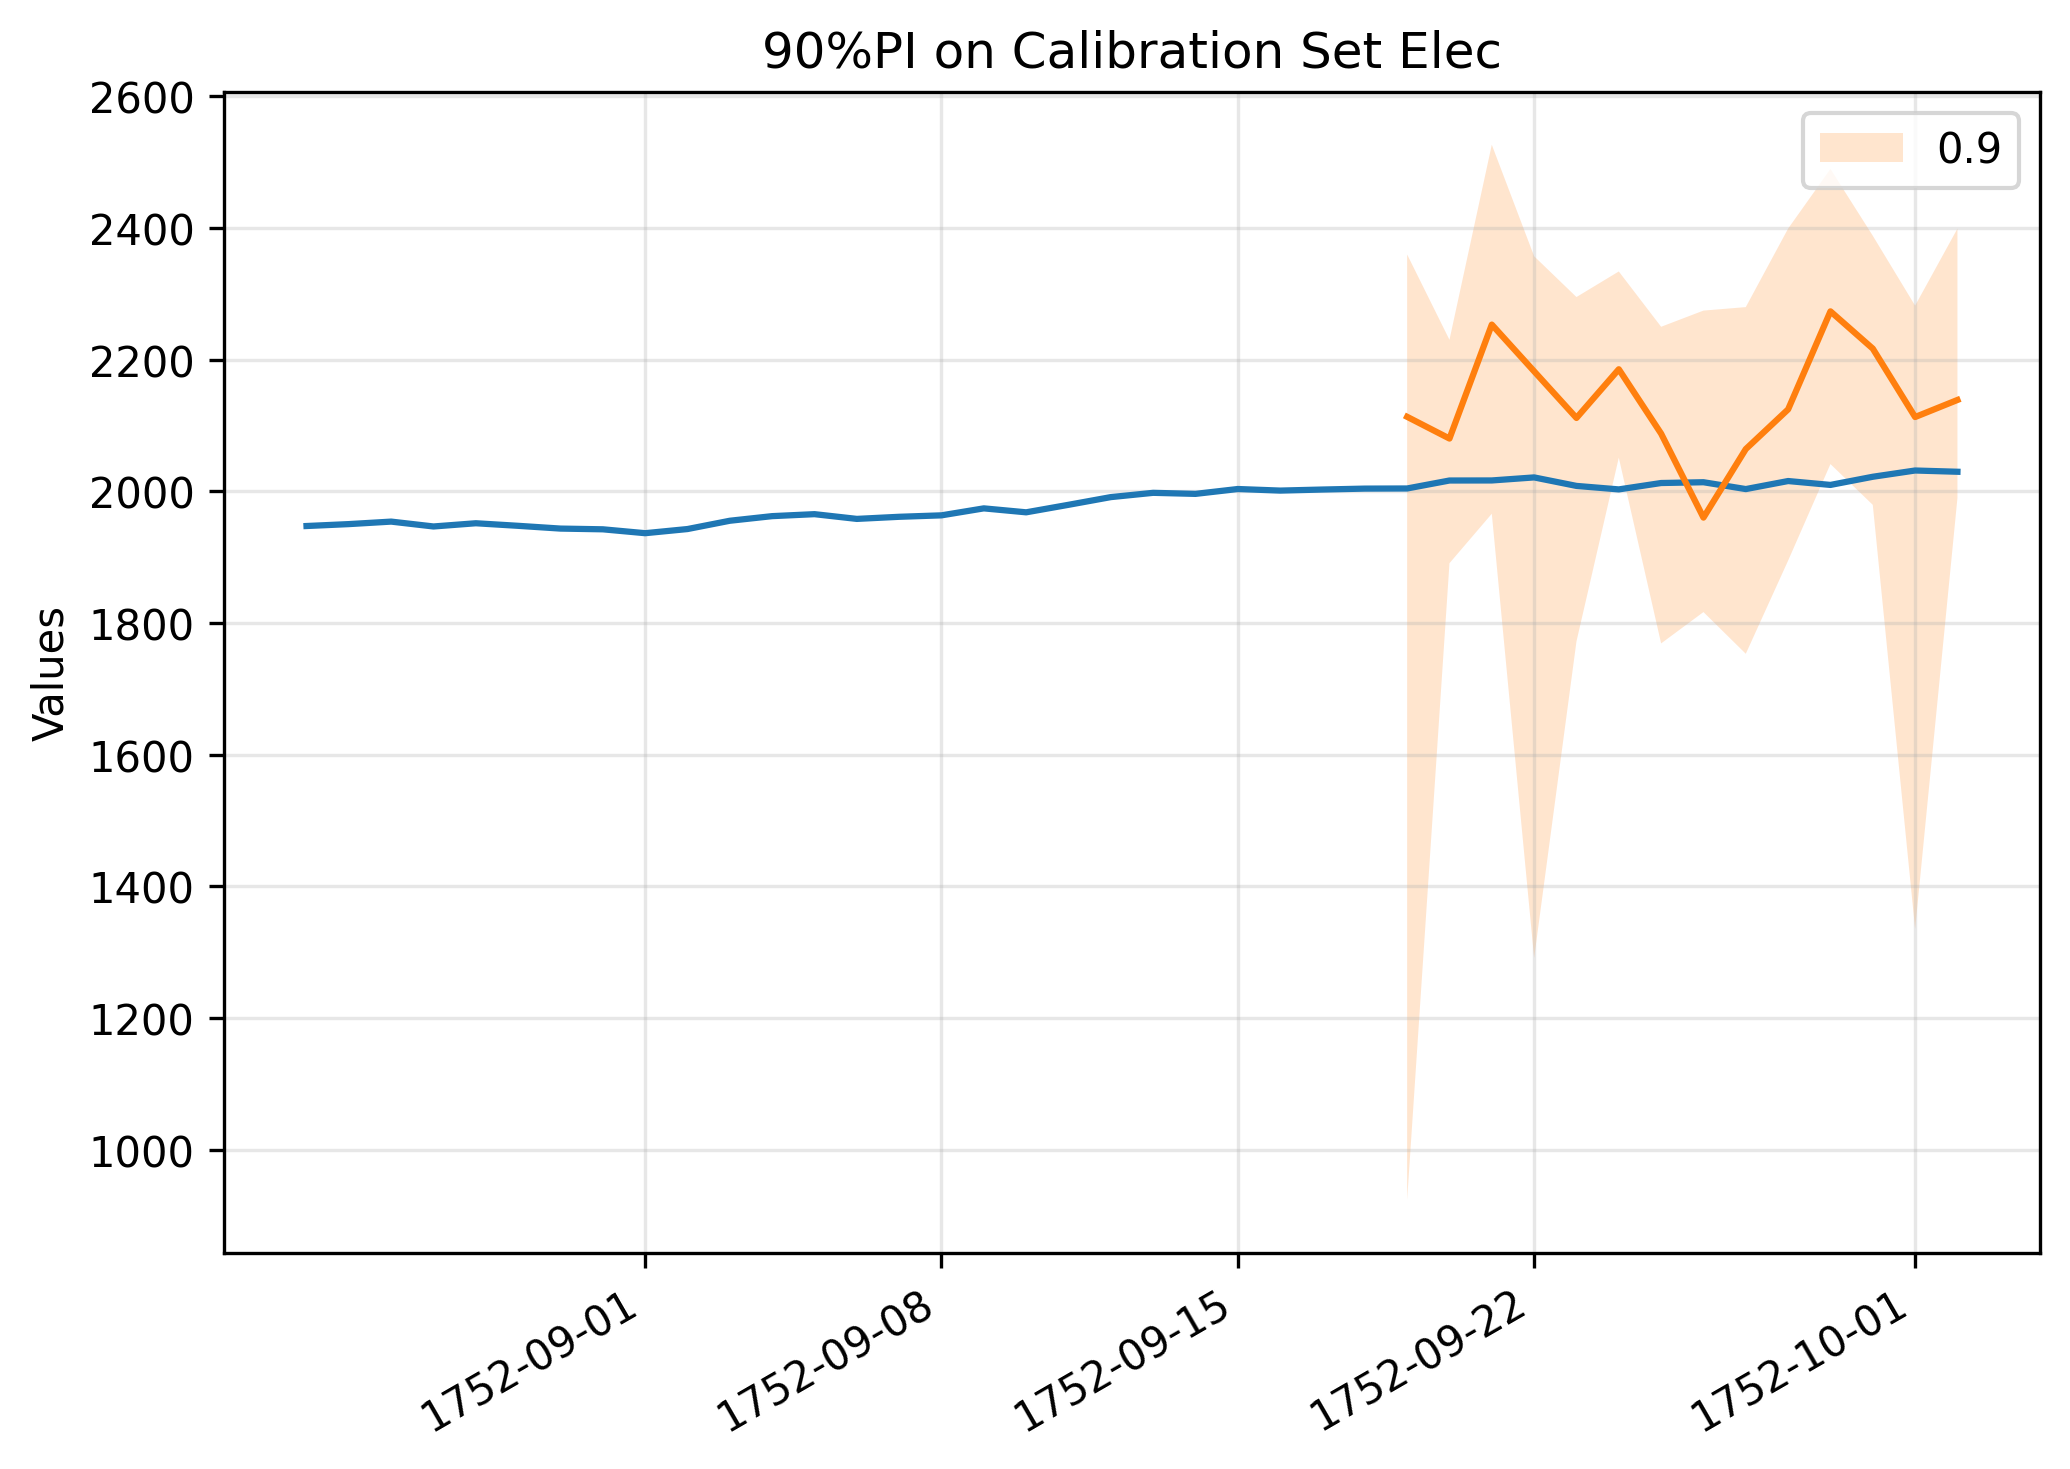

In [85]:
fig, ax = plt.subplots(dpi=300)
ax.plot(tss[0][-40:].to_timestamp())
calibrate_it[0].plot(intervals=[0.90],show_label=True)
plt.title("90%PI on Calibration Set Elec")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

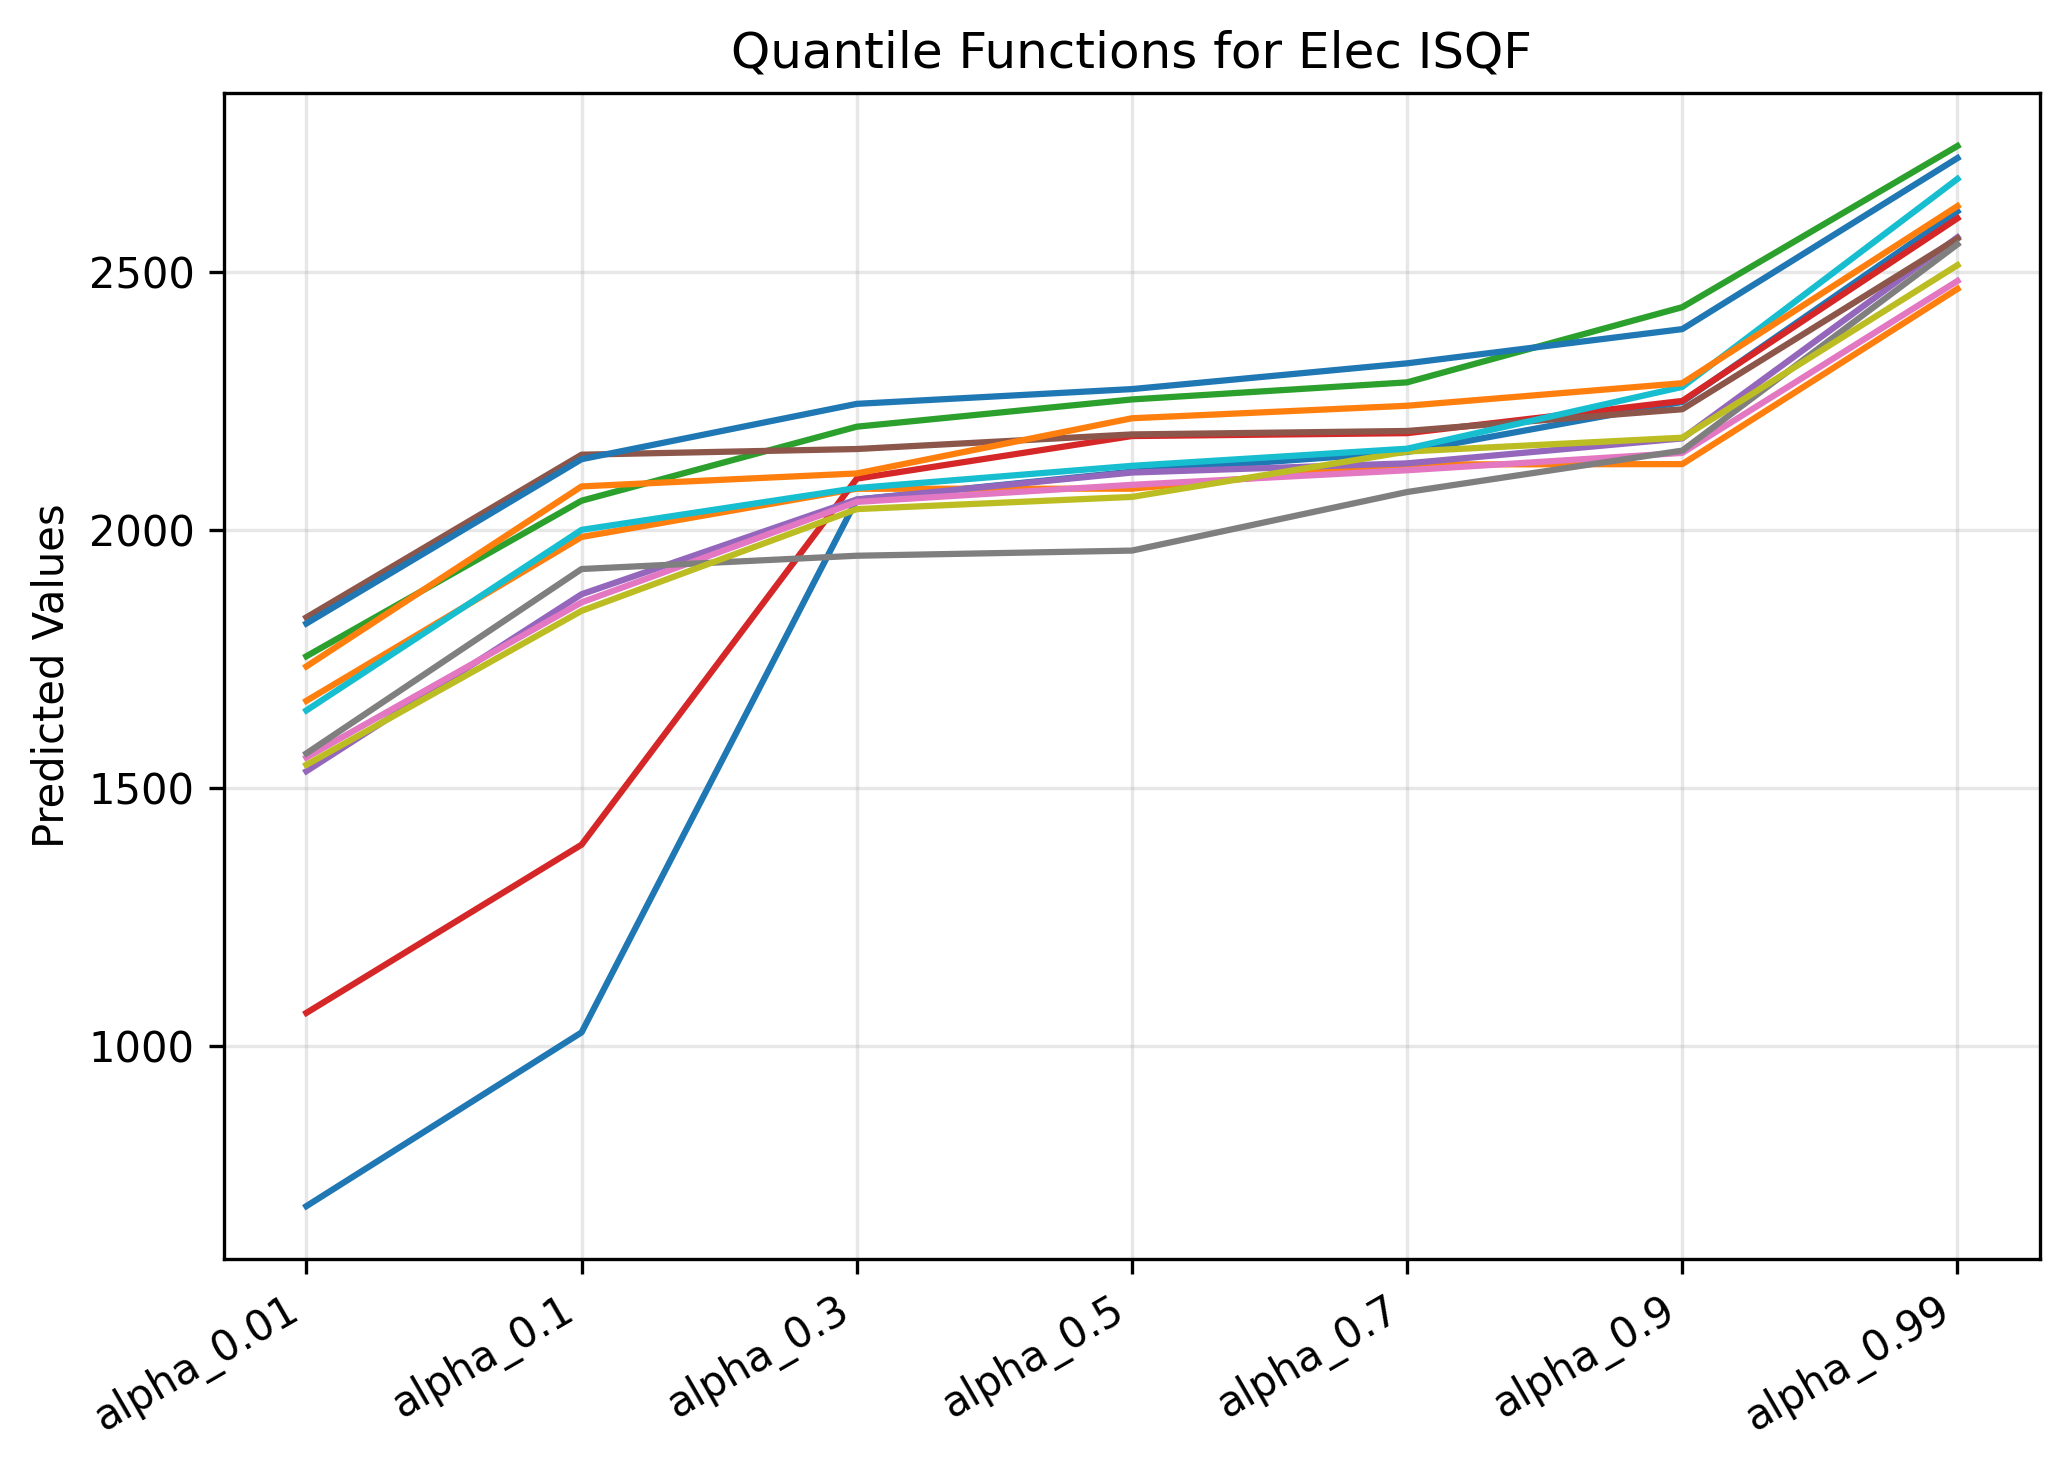

In [87]:
quantiles = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
calib_quantiles_df = pd.DataFrame({
    f'alpha_{q}': calibrate_it[0].quantile(q) for q in quantiles
})

# Plot some quantile functions
fig, ax = plt.subplots(dpi=300)
for r in range(12):
  ax.plot(calib_quantiles_df.iloc[r])

plt.ylabel('Predicted Values')
plt.title('Quantile Functions for M4 ISQF')
plt.grid(alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()

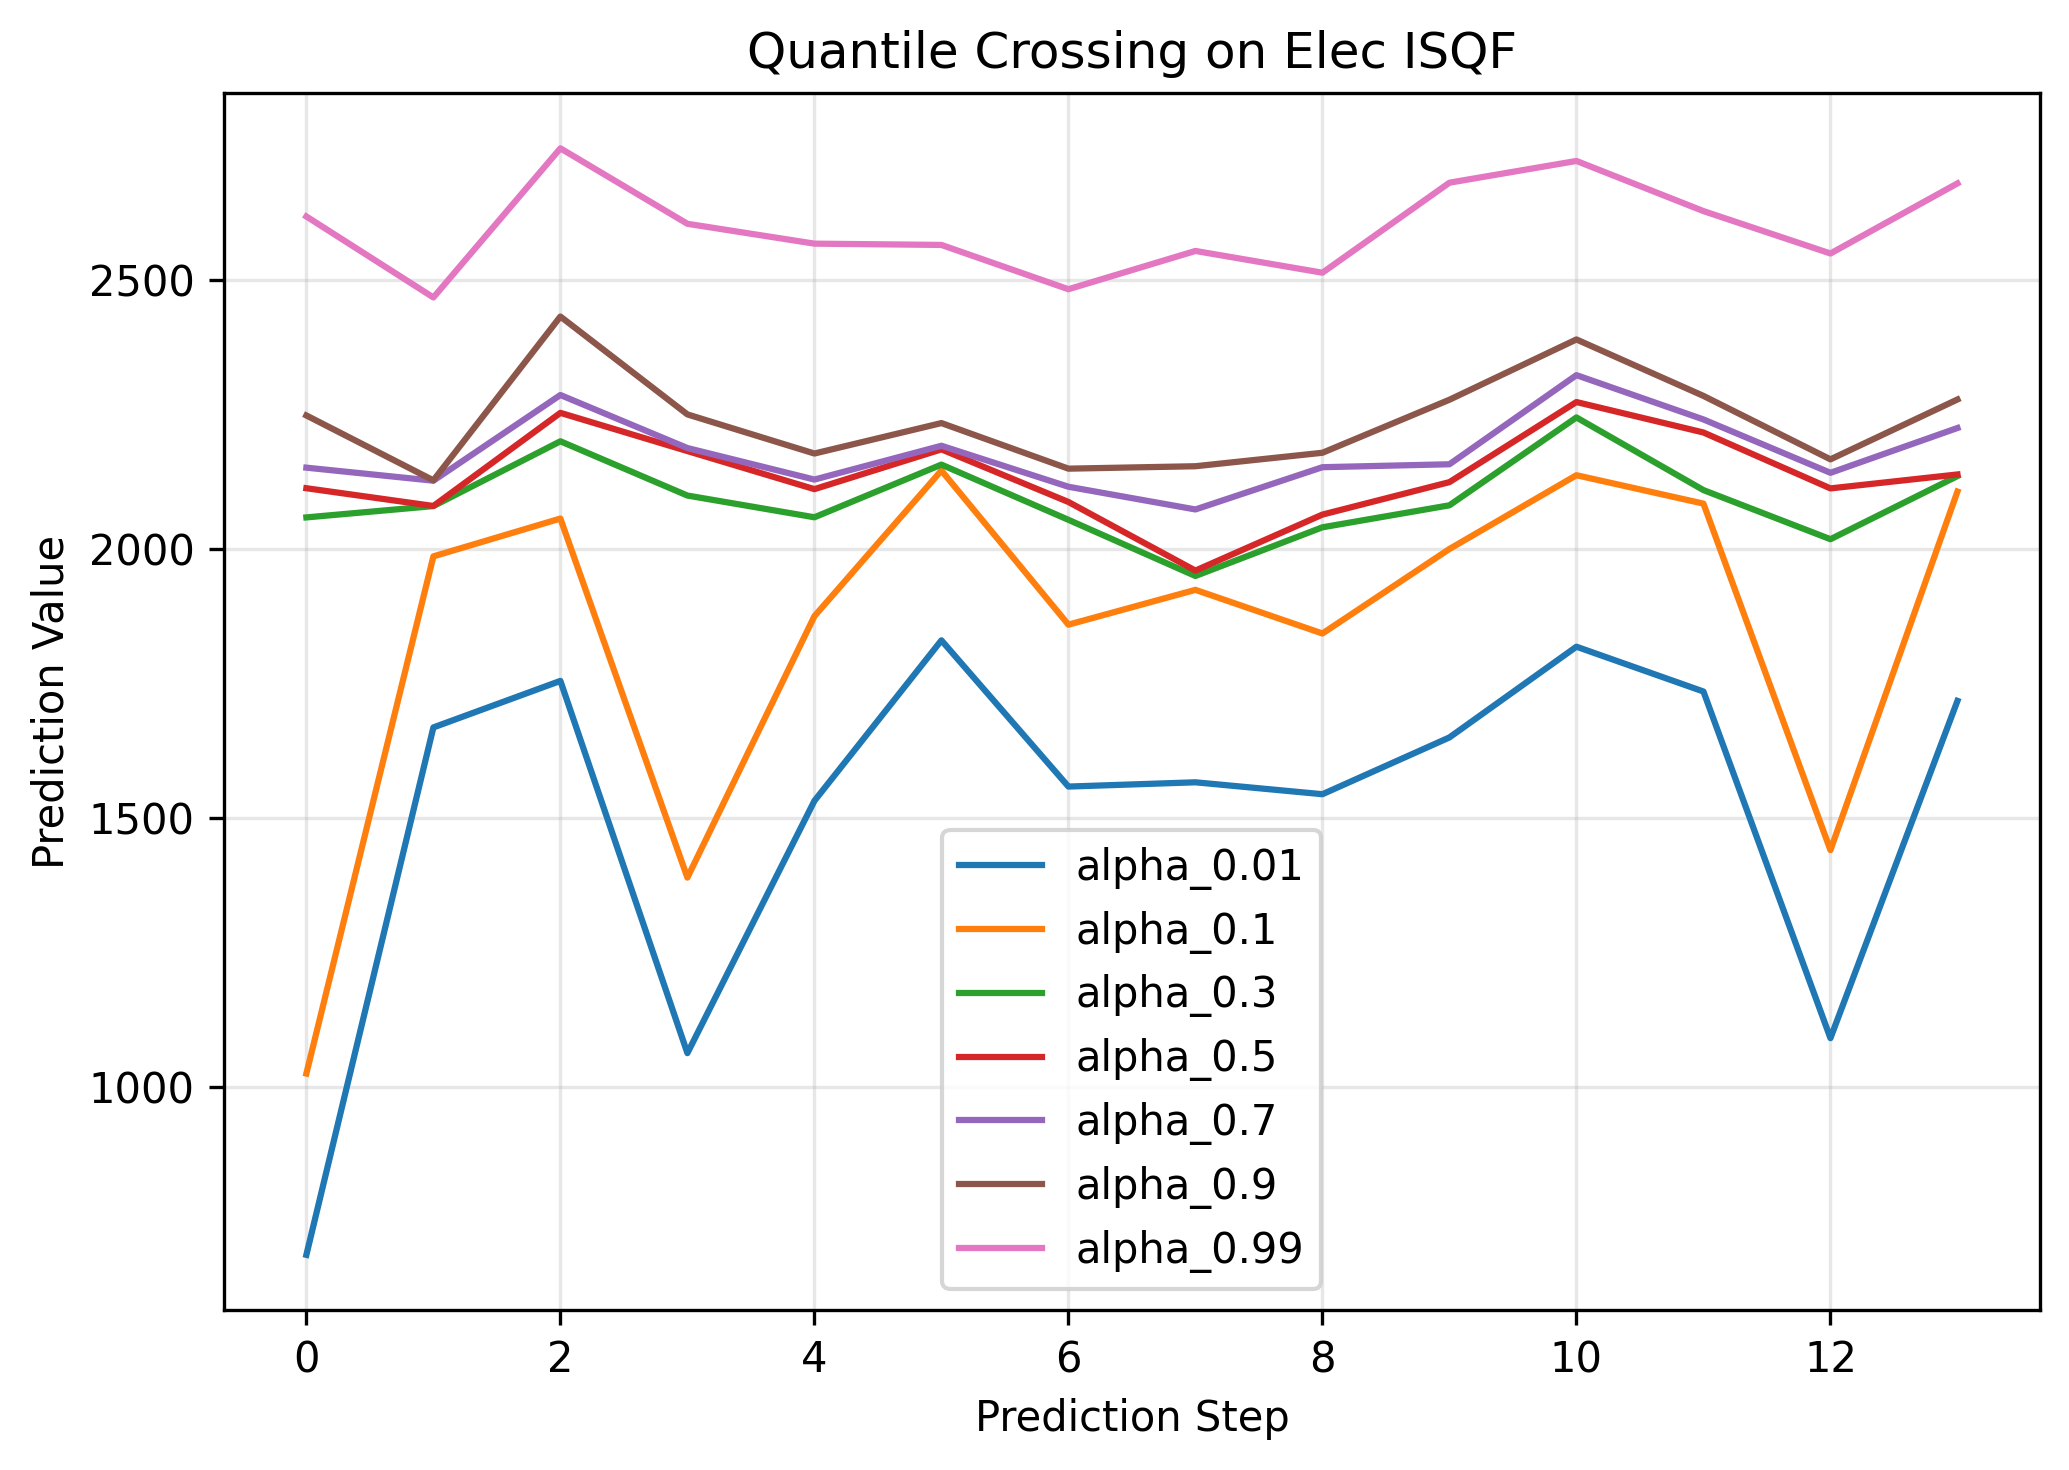

In [88]:
fig, ax = plt.subplots(dpi=300)

for c in calib_quantiles_df.columns:
  ax.plot(calib_quantiles_df.loc[:,c], label=c)

plt.ylabel('Prediction Value')
plt.xlabel('Prediction Step')
plt.title('Quantile Crossing on Elec ISQF')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

In [89]:
evaluator = Evaluator(quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
agg_metrics, item_metrics = evaluator(tss, calibrate_it)
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 1it [00:00,  6.75it/s]


{
    "MSE": NaN,
    "abs_error": 1802.8369140625,
    "abs_target_sum": 28207.8984375,
    "abs_target_mean": 2014.849888392857,
    "seasonal_error": 4.41049523839556,
    "MASE": 29.19718950587139,
    "MAPE": 0.06391927174159459,
    "sMAPE": 0.0615179751600538,
    "MSIS": 183.06298813593403,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 1367.827001953125,
    "Coverage[0.1]": 0.35714285714285715,
    "QuantileLoss[0.2]": 1877.8845703125,
    "Coverage[0.2]": 0.8571428571428571,
    "QuantileLoss[0.3]": 1668.4084228515626,
    "Coverage[0.3]": 0.8571428571428571,
    "QuantileLoss[0.4]": 1933.7552734375001,
    "Coverage[0.4]": 0.9285714285714286,
    "QuantileLoss[0.5]": 1802.8369140625,
    "Coverage[0.5]": 0.9285714285714286,
    "QuantileLoss[0.6]": 1751.1298828125002,
    "Coverage[0.6]": 1.0,
    "QuantileLoss[0.7]": 1377.9355957031253,
    "Coverage[0.7]": 1.0,
    "QuantileLoss[0.8]": 996.7770507812496,
    "Coverage[0.8]": 1.0,
    "QuantileLoss[0.9]": 62

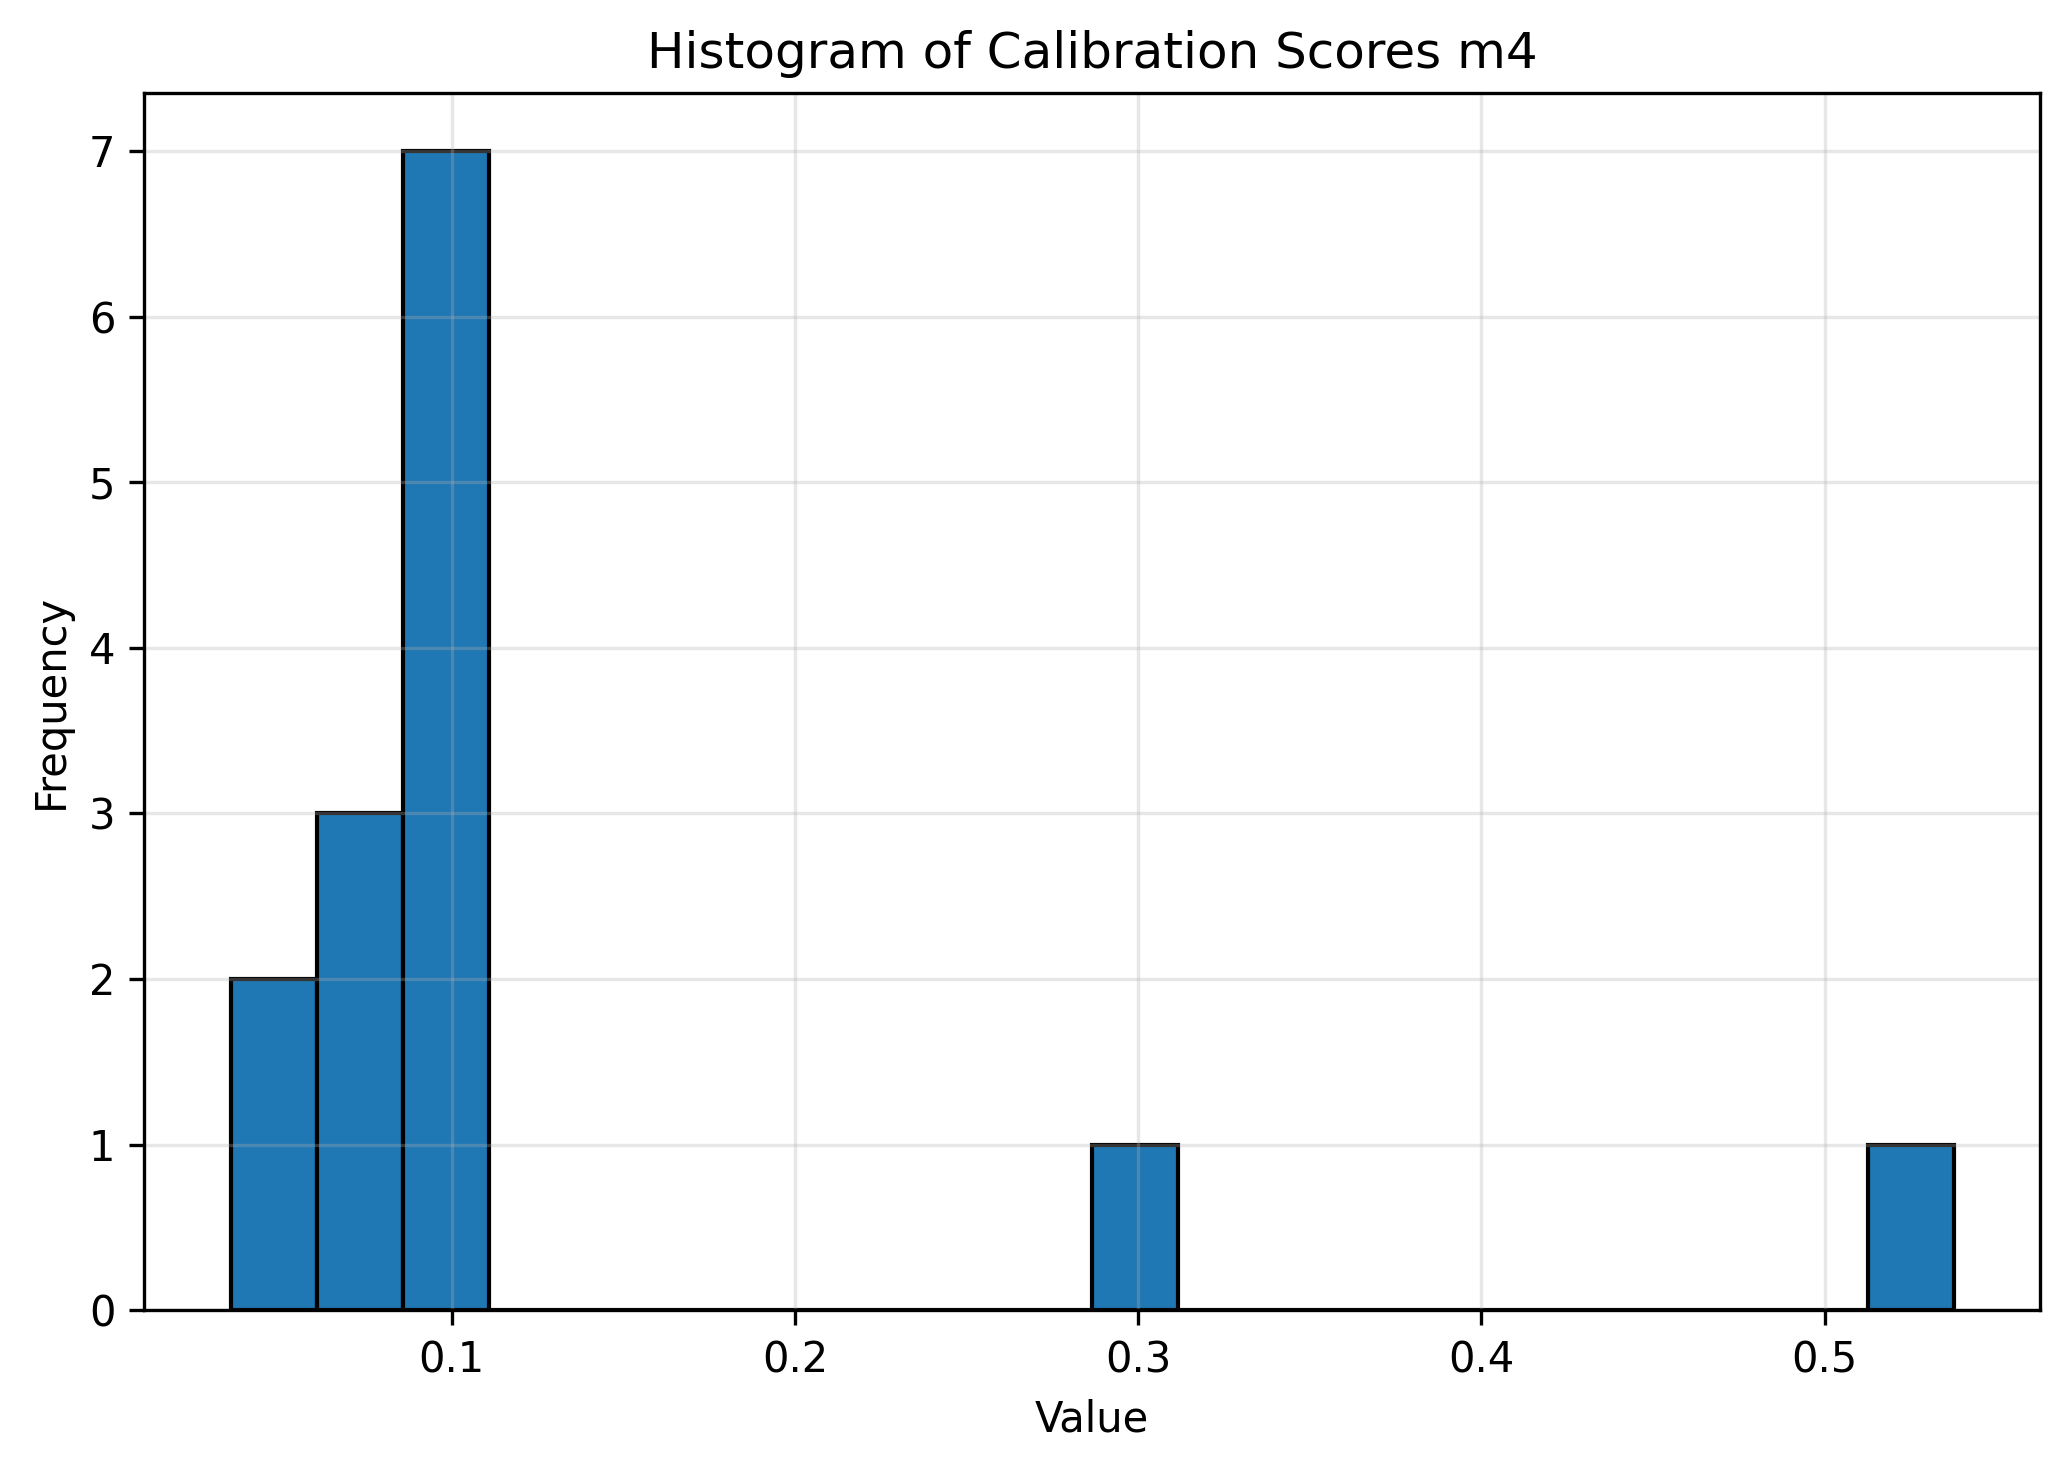

In [91]:
calib_set = []
valid_ds = tss[0][-14:][0]
valid_idx = valid_ds.index
for date, y in zip(valid_idx, valid_ds.values):
  q_hat = binary_search_for_alpha(y, date, calibrate_it[0])
  calib_set.append(q_hat)
calib_set.sort()

fig, ax = plt.subplots(dpi=300)
ax.hist(calib_set, bins=20, edgecolor='black')
ax.set_title('Histogram of Calibration Scores m4')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()


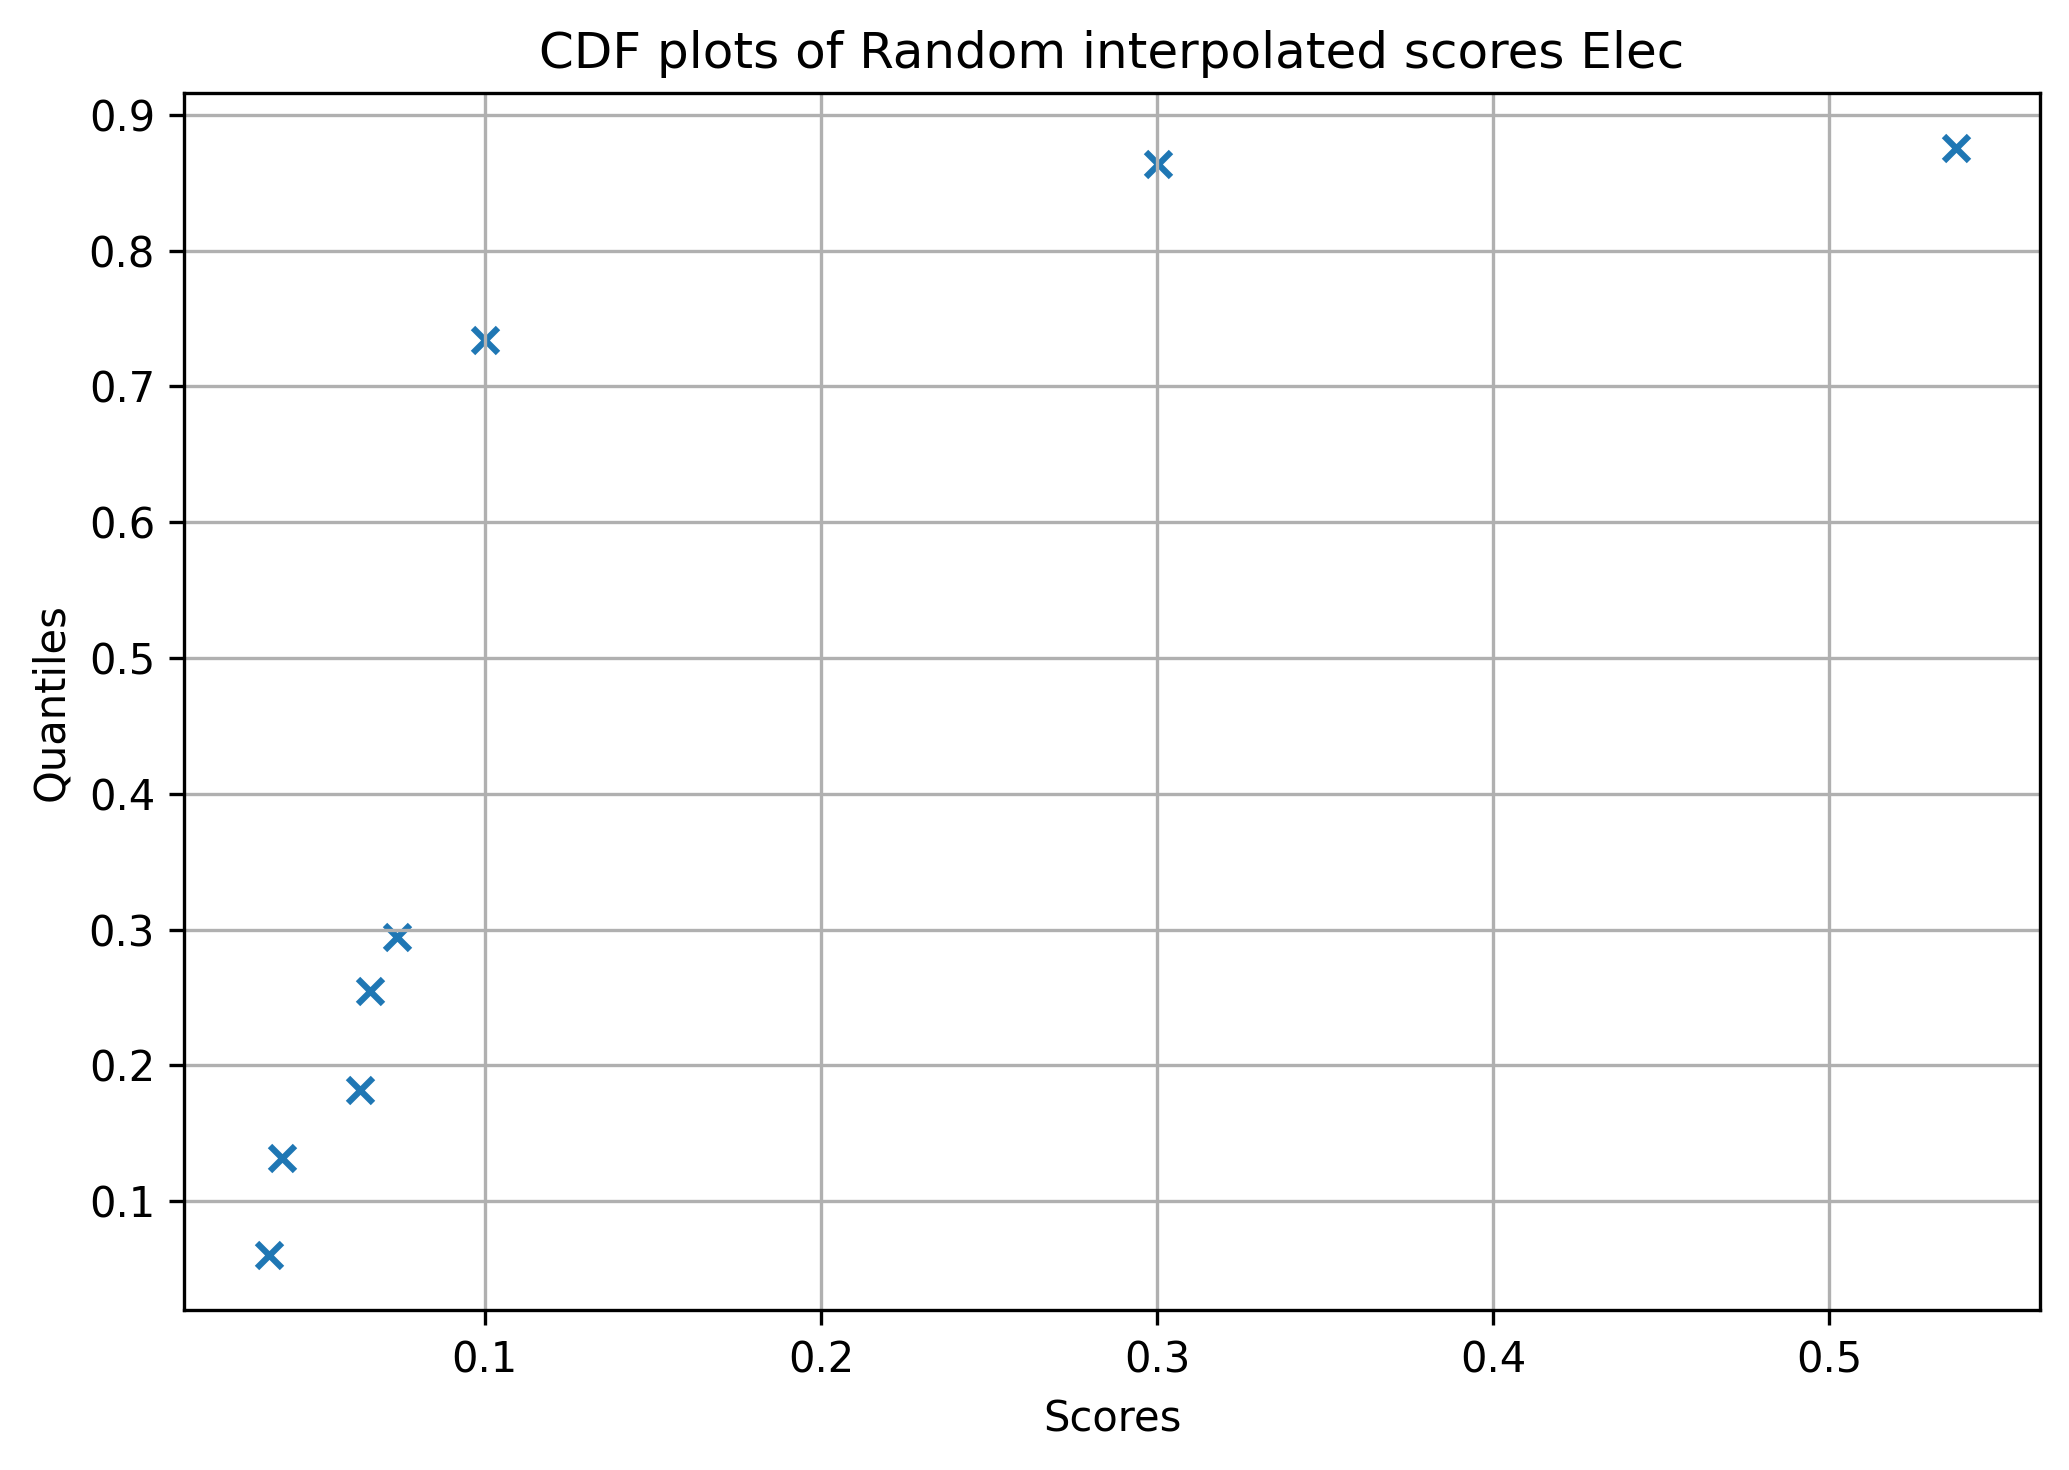

In [92]:
inter = interpolation_random(calib_set)
fig, ax = plt.subplots(dpi=300)
ax.scatter(inter.keys(), inter.values(), marker='x')
plt.title('CDF plots of Random interpolated scores Elec')
plt.xlabel('Scores')
plt.ylabel('Quantiles')
plt.grid(True)
plt.tight_layout()

In [93]:
start = pd.Period('1750-01-01', freq='D')
m4_test = m4_test_series.values.reshape(1,-1)
test_m4_ds = ListDataset(
    [{"target": x, "start": start} for x in m4_test], freq='D'
)
test_it, ts_it = make_evaluation_predictions(
    dataset=test_m4_ds,  # calibration dataset
    predictor=m4_predictor,  # predictor
)

test_it = list(test_it)
tss = list(ts_it)

In [94]:
inter

{0.03564453125: 0.06041637422233099,
 0.03955078125: 0.131970888770735,
 0.06298828125: 0.18162312265613023,
 0.06591796875: 0.25450621745172974,
 0.07373046875: 0.294497657330081,
 0.10009765625: 0.7338282714552034,
 0.30029296875: 0.8638233369408415,
 0.53759765625: 0.8753551804678087}

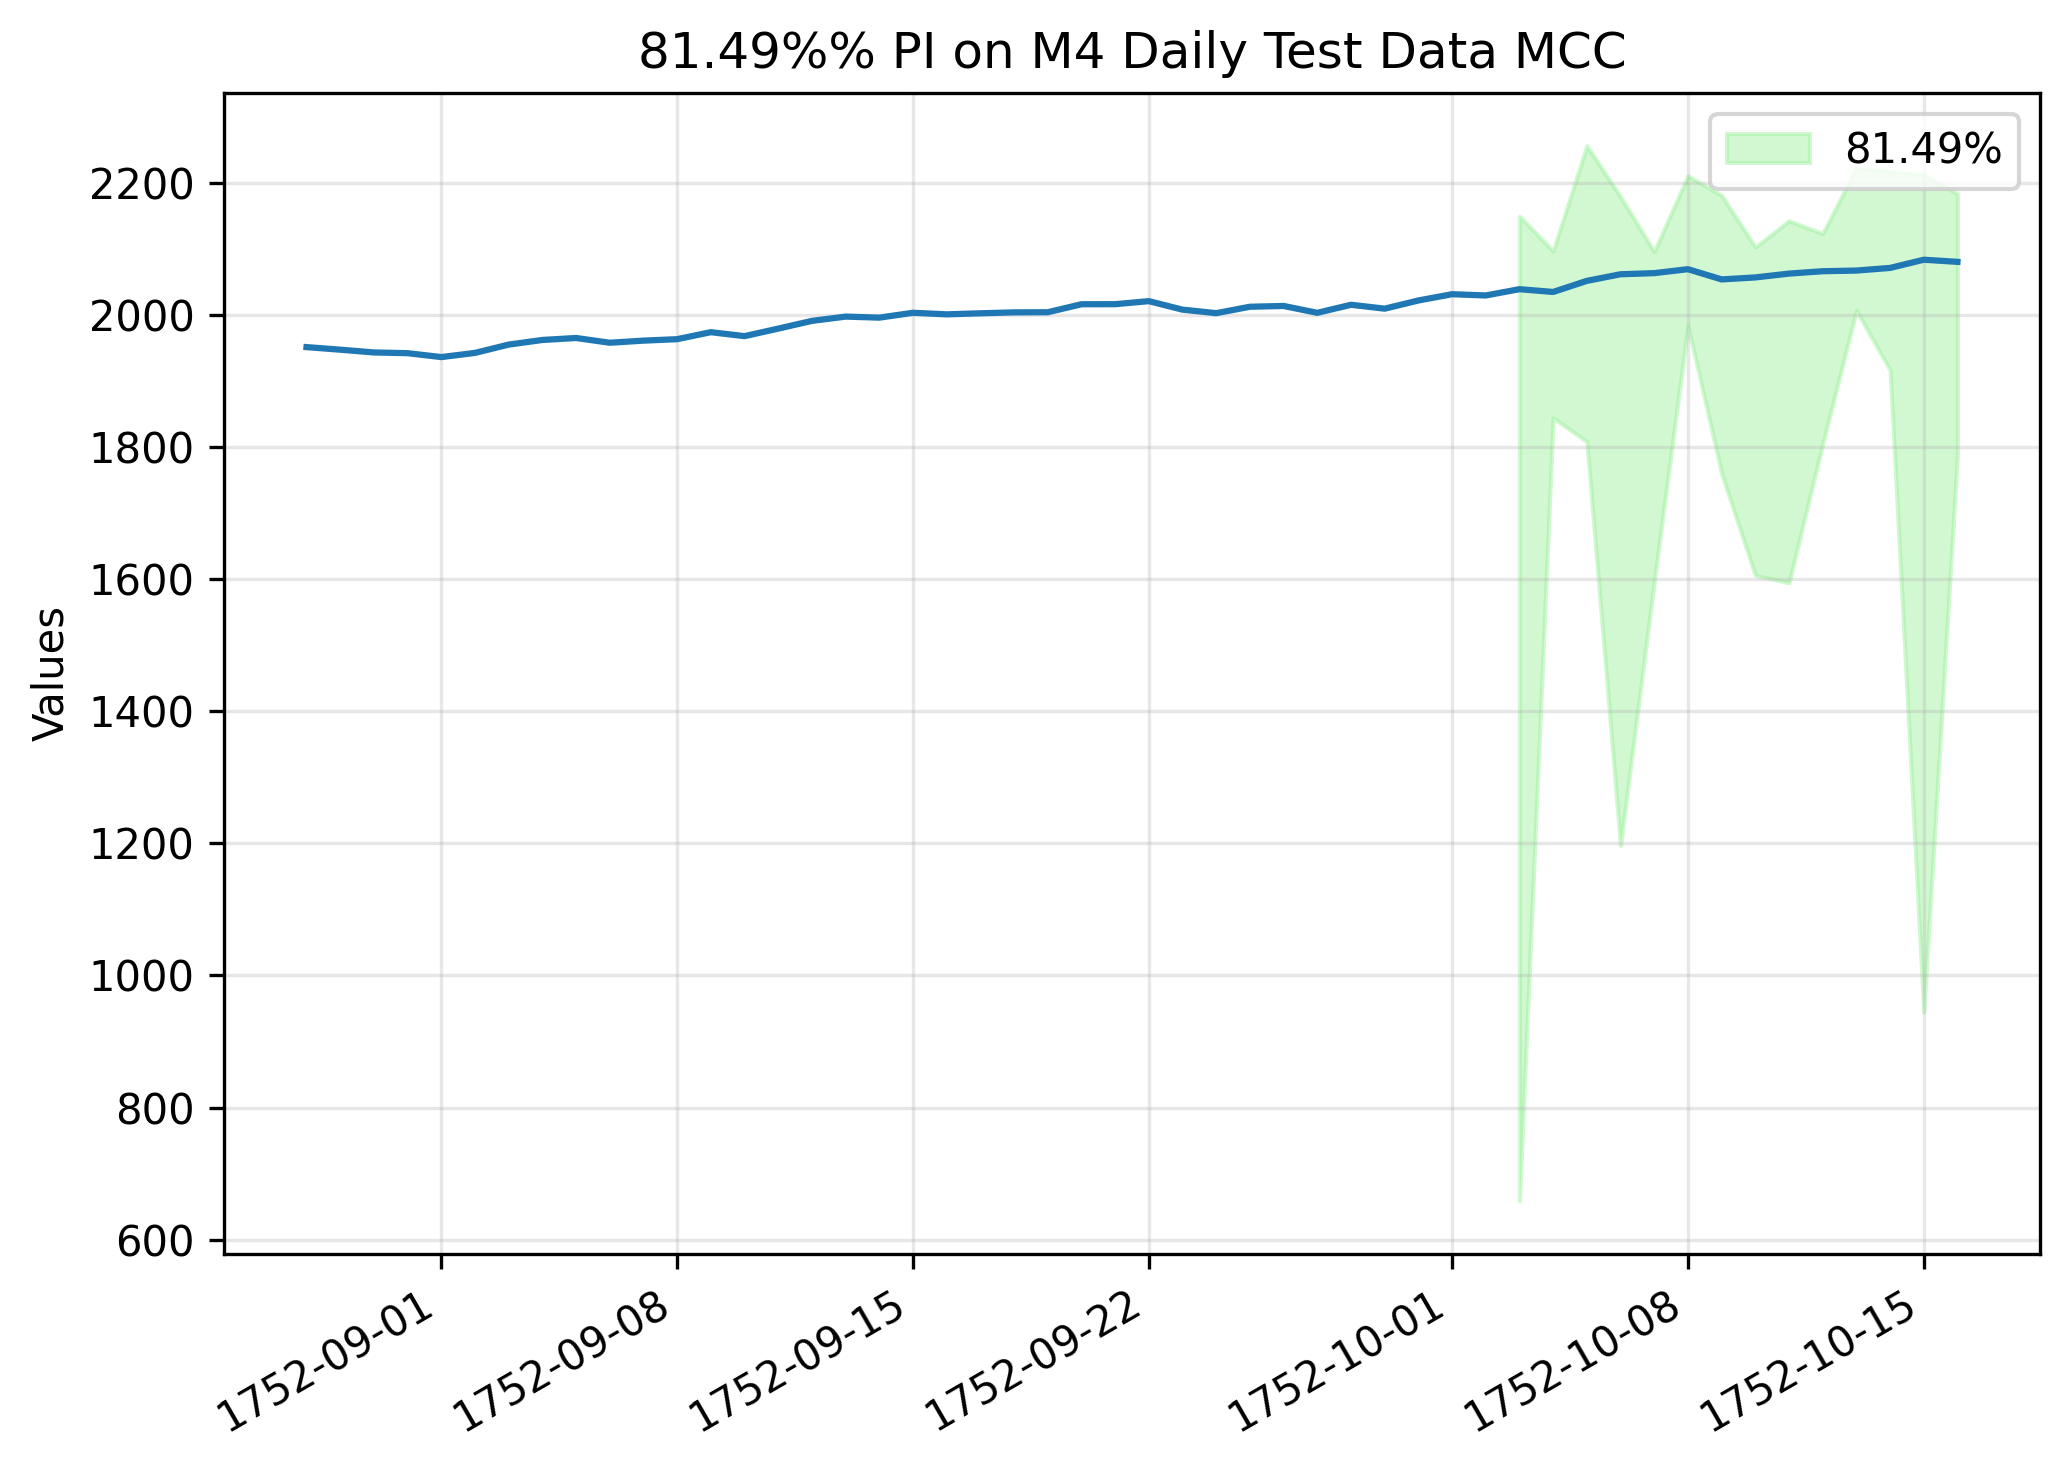

In [100]:
lq, uq = min(inter.keys()), max(inter.keys())
percentage_coverage = round((inter[uq] - inter[lq]),4)
p_str = str(percentage_coverage  * 100)+'%'
lb = test_it[0].quantile_ts(lq)
up = test_it[0].quantile_ts(uq)
dates = lb.index.to_timestamp().tolist()
fig, ax = plt.subplots(dpi=300)
ax.plot(tss[0][-50:].to_timestamp())
# test_it[0].plot(intervals=[percentage_coverage ],show_label=True)
ax.fill_between(dates, lb, up, color='lightgreen', alpha=0.4, label=p_str)
plt.title(f"{p_str}% PI on M4 Daily Test Data MCC")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.legend()
fig.autofmt_xdate()
plt.tight_layout()

In [101]:
difference = up - lb

# Calculate the mean and standard deviation of the difference
mean_diff = np.mean(difference)
std_diff = np.std(difference)

mean_diff, std_diff

(561.9605, 383.76105)

In [43]:
evaluator = Evaluator(quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
agg_metrics, item_metrics = evaluator(tss, test_it)
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 1it [00:00,  3.35it/s]


{
    "MSE": NaN,
    "abs_error": 1033.8367919921875,
    "abs_target_sum": 28864.203125,
    "abs_target_mean": 2061.7287946428573,
    "seasonal_error": 4.4469663401741295,
    "MASE": 16.605811578822866,
    "MAPE": 0.035816924912588935,
    "sMAPE": 0.036617709057671685,
    "MSIS": 137.4400478860245,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 362.42138671875006,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.2]": 593.8875976562499,
    "Coverage[0.2]": 0.07142857142857142,
    "QuantileLoss[0.3]": 861.5916503906251,
    "Coverage[0.3]": 0.07142857142857142,
    "QuantileLoss[0.4]": 1035.8893554687497,
    "Coverage[0.4]": 0.07142857142857142,
    "QuantileLoss[0.5]": 1033.8367919921875,
    "Coverage[0.5]": 0.21428571428571427,
    "QuantileLoss[0.6]": 1183.8042480468748,
    "Coverage[0.6]": 0.21428571428571427,
    "QuantileLoss[0.7]": 897.9617919921874,
    "Coverage[0.7]": 0.2857142857142857,
    "QuantileLoss[0.8]": 947.9917968750001,
    "Coverage[0.8]": 0